This notebook contains various visualization to gauge cleaning success and its effect(s) on next activity prediction, in a somewhat more compact way than the other notebook. This notebook also features correlation analyses.

# SETUP

##Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

## Globals

In [ ]:
pollution_types_1 = ["DISTORTED", "POLLUTED.NORND", "POLLUTED.RANDOM"]
pollution_types_2 = ["DISTORTED-activity", "POLLUTED.NORND-activity", "POLLUTED.RANDOM-activity", "SYNONYM", "HOMONYM"]
pollution_types_3 = ["DISTORTED-activity", "POLLUTED.NORND-activity", "POLLUTED.RANDOM-activity", "SYNONYM"]
percentages = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
percentages_0 = [0., 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

dataset_converter = {
    "BPIC11_f1": "BPIC'11",
    "BPIC15_1_f2": "BPIC'15",
    "Credit": "Credit",
    "Pub": "Pub"
}

label_converter = {
    "overall_accuracy": "Average Evaluation Accuracy",
    "overall_precision": "Average Evaluation Precision",
    "overall_recall": "Average Evaluation Recall",
    "overall_fscore": "Average Evaluation F1-Score"
}

key_converter = {
    "DISTORTED-activity": "DISTORTED",
    "POLLUTED.NORND-activity": "POLLUTED.NORND",
    "POLLUTED.RANDOM-activity": "POLLUTED.RANDOM",
    "DISTORTED": "DISTORTED",
    "POLLUTED.NORND": "POLLUTED.NORND",
    "POLLUTED.RANDOM": "POLLUTED.RANDOM",
    "SYNONYM": "SYNONYM",
    "HOMONYM": "HOMONYM"
}

cleaning_methods = ["CLUSTERING", "CLUSTERING-HAMMING", "SEQUENCES"]

key_converter_eval = {
    "CLUSTERING": "clustering_cleaning/Levenshtein",
    "CLUSTERING-HAMMING": "clustering_cleaning/Hamming",
    "SEQUENCES": "sequences_cleaning"
}

key_converter_cleaning = {
    "clustering-lev": "clustering_cleaning/Levenshtein",
    "clustering-ham": "clustering_cleaning/Hamming",
    "sequences": "sequences_cleaning"
}

metric_converter = {
    "UNKNOWNS":"Average UNKNOWNS after cleaning",
    "AVG_DISTINCT_PER_CASE":"Average AVG_DISTINCT_PER_CASE after cleaning",
    "UNIQUENESS":"Average UNIQUENESS after cleaning",
    "f1":"Average Reconstruction F1-score after cleaning"
}

metric_converter2 = {
    "UNKNOWNS":"UNKNOWNS",
    "AVG_DISTINCT_PER_CASE":"AVG_DPC",
    "UNIQUENESS":"UNIQUENESS",
    "f1":"Recons. F1",
    "time":"Clean. time"
}

pol2Int = {
    "DISTORTED": 1,
    "POLLUTED.NORND": 2,
    "POLLUTED.RANDOM": 3,
    "DISTORTED-activity": 1,
    "POLLUTED.NORND-activity":2,
    "POLLUTED.RANDOM-activity": 3,
    "SYNONYM": 4,
    "HOMONYM": 5
}

dataset2Short = {
    "BPIC11_f1": "BPIC11",
    "BPIC15_1_f2": "BPIC15",
    "Credit": "Credit",
    "Pub": "Pub"
}

## Functions

In [ ]:
def fetch_cleaning_scores(dataset, pollution_types):
  uncleaned_scores = []
  for pollution_type in pollution_types:
    with open(f"{dataset}/{dataset}/REFERENCE_{dataset}_{pollution_type}.pickle", "rb") as f:
      uncleaned_scores.append(pickle.load(f))
  uncleaned_scores = dict(zip(pollution_types, uncleaned_scores))

  clustering_scores = []
  for pollution_type in pollution_types:
    with open(f"{dataset}/{dataset}/CLEANING_{dataset}_{pollution_type}_clustering.pickle", "rb") as f:
      clustering_scores.append(pickle.load(f))
  clustering_scores = dict(zip(pollution_types, clustering_scores))

  hamming_scores = []
  for pollution_type in pollution_types:
    with open(f"{dataset}/{dataset}/CLEANING_{dataset}_{pollution_type}_clustering-HAMMING.pickle", "rb") as f:
      hamming_scores.append(pickle.load(f))
  hamming_scores = dict(zip(pollution_types, hamming_scores))

  sequences_scores = []
  for pollution_type in pollution_types:
    with open(f"{dataset}/{dataset}/CLEANING_{dataset}_{pollution_type}_sequences.pickle", "rb") as f:
      sequences_scores.append(pickle.load(f))
  sequences_scores = dict(zip(pollution_types, sequences_scores))

  return uncleaned_scores, clustering_scores, hamming_scores, sequences_scores

In [ ]:
# TODO: clean this code

profiling_metrics = ['UNKNOWNS', 'UNIQUENESS', 'AVG_DISTINCT_PER_CASE']
dq_scorings = ["f1"]
metrics = profiling_metrics+dq_scorings

def show_compact(dataset, pollution_type):

  if dataset == "BPIC11_f1":
    pollution_types = pollution_types_1
  elif dataset == "BPIC15_1_f2":
    pollution_types = pollution_types_1
  elif dataset == "Credit":
    pollution_types = pollution_types_2
  elif dataset == "Pub":
    pollution_types = pollution_types_3

  uncleaned_scores, clustering_scores, hamming_scores, sequences_scores = fetch_cleaning_scores(dataset, pollution_types)

  with open(f'./{dataset}/{dataset}/AVG_SCORES_{dataset}-TRAIN-{pollution_type}.pickle', 'rb') as f:
      eval_uncleaned_score = pickle.load(f)

  eval_cleaned_scores = {}
  for cleaning_method in cleaning_methods:
    with open(f'./{dataset}/{dataset}/AVG_SCORES_{dataset}-TRAIN-{pollution_type}-CLEANED-{cleaning_method}.pickle', 'rb') as f:
      eval_cleaned_scores[cleaning_method] = pickle.load(f)

  fig, axes = plt.subplots(2, 3, figsize=(40, 15)) #tentative
  axes = axes.flatten()

  ### time

  # clustering_cleaning
  y = [clustering_scores[pollution_type][percentage]['time'] for percentage in percentages]
  axes[0].plot(percentages, y, marker="o", label=key_converter_cleaning["clustering-lev"], linewidth=3, color='red')

  # clustering_cleaning-HAMMING
  y = [hamming_scores[pollution_type][percentage]['time'] for percentage in percentages]
  axes[0].plot(percentages, y, marker="o", label=key_converter_cleaning["clustering-ham"], linewidth=3, color='green')

  # sequences_cleaning
  y = [sequences_scores[pollution_type][percentage]['time'] for percentage in percentages]
  axes[0].plot(percentages, y, marker="o", label=key_converter_cleaning["sequences"], linewidth=3, color='blue')

  axes[0].set_yscale('log')

  axes[0].set_xlabel("Corruption percentage")
  axes[0].set_ylabel('time (seconds)')
  axes[0].set_title(f"Average cleaning time (log scale)")
  axes[0].legend()
  axes[0].grid(True)

  ### Profiling

  for i, metric in enumerate(metrics):

    # Original
    y = [uncleaned_scores[pollution_type][percentage][metric] for percentage in percentages_0]
    axes[i+1].plot(percentages_0, y, linestyle="dashed", marker="o", label="original", linewidth=3, color='brown')

    # clustering_cleaning
    y = [clustering_scores[pollution_type][percentage][metric] for percentage in percentages]
    axes[i+1].plot(percentages, y, marker="o", label=key_converter_cleaning["clustering-lev"], linewidth=3, color='red')

    # clustering_cleaning-HAMMING
    y = [hamming_scores[pollution_type][percentage][metric] for percentage in percentages]
    axes[i+1].plot(percentages, y, marker="o", label=key_converter_cleaning["clustering-ham"], linewidth=3, color='green')

    # sequences_cleaning
    y = [sequences_scores[pollution_type][percentage][metric] for percentage in percentages]
    axes[i+1].plot(percentages, y, marker="o", label=key_converter_cleaning["sequences"], linewidth=3, color='blue')

    axes[i+1].set_xlabel("Corruption percentage")
    axes[i+1].set_ylabel(metric_converter[metric])
    axes[i+1].set_title(f"{metric_converter[metric]}")
    axes[i+1].legend()
    axes[i+1].grid(True)

  ### Eval

  colors = iter(['red', 'green', 'blue'])

  for i, score in enumerate(["overall_fscore"]):
    y = [eval_uncleaned_score[percentage][score] for percentage in percentages_0]
    axes[-1].plot(percentages_0, y, linestyle="dashed", marker="o", label="Uncleaned", linewidth=3, color='brown')

    for j, cleaning_method in enumerate(cleaning_methods):
      y = [eval_cleaned_scores[cleaning_method][percentage][score] for percentage in percentages]
      axes[-1].plot(percentages, y, linestyle="-", marker="o", label=key_converter_eval[cleaning_method], linewidth=3, color=next(colors))
    axes[-1].set_xlabel("Corruption percentage")
    axes[-1].set_ylabel(label_converter[score])
    axes[-1].set_title(f"{label_converter[score]} after cleaning")
    axes[-1].legend()
    axes[-1].grid(True)


  #fig.suptitle(f"Summary statistics of dataset {dataset_converter[dataset]} with {pollution_type} imperfection before and after cleaning with different techniques", y=1)
  fig.tight_layout()
  plt.savefig(f"profiling_{dataset2Short[dataset]}_{pol2Int[pollution_type]}.png", bbox_inches='tight')
  fig.show()

In [ ]:
def correlation_analysis(dataset):

  if dataset == "BPIC11_f1":
    pollution_types = pollution_types_1
  elif dataset == "BPIC15_1_f2":
    pollution_types = pollution_types_1
  elif dataset == "Credit":
    pollution_types = pollution_types_2
  elif dataset == "Pub":
    pollution_types = pollution_types_3

  corrs = []

  for pollution_type in pollution_types: # by pollution type

    with open(f'./{dataset}/{dataset}/AVG_SCORES_{dataset}-TRAIN-{pollution_type}.pickle', 'rb') as f:
        eval_uncleaned_score = pickle.load(f)

    eval_cleaned_scores = {}
    for cleaning_method in cleaning_methods:
      with open(f'./{dataset}/{dataset}/AVG_SCORES_{dataset}-TRAIN-{pollution_type}-CLEANED-{cleaning_method}.pickle', 'rb') as f:
        eval_cleaned_scores[cleaning_method] = pickle.load(f)

    eval_cleaned_scores['None'] = eval_uncleaned_score

    scores_dict = dict(zip(['None', 'CLUSTERING','CLUSTERING-HAMMING','SEQUENCES'],fetch_cleaning_scores(dataset, pollution_types)))

    for method_name in scores_dict:

      scores4corr = {}
      for metric in ["time", "UNKNOWNS", "UNIQUENESS", "AVG_DISTINCT_PER_CASE", "f1"]:
        scores4corr[metric_converter2[metric]] = [scores_dict[method_name][pollution_type][rate][metric] for rate in percentages]

      scores4corr2 = {}
      for metric in ["overall_fscore"]:
        scores4corr2["Eval. F1"] = [eval_cleaned_scores[method_name][rate][metric] for rate in percentages]

      df_corr = pd.DataFrame(scores4corr)
      df_corr["Eval. F1"] = scores4corr2["Eval. F1"]

      corrs.append(df_corr.corr(method = 'pearson'))

  temp = corrs[0].copy()
  for i in range(len(temp)):
    for j in range(len(temp.columns)):
      temp.iloc[i,j] = np.nanmean(np.array([corrs[k].iloc[i,j] for k in range(len(corrs))]))

  temp

  return temp

# BPIC11

In [ ]:
dataset = "BPIC11_f1"

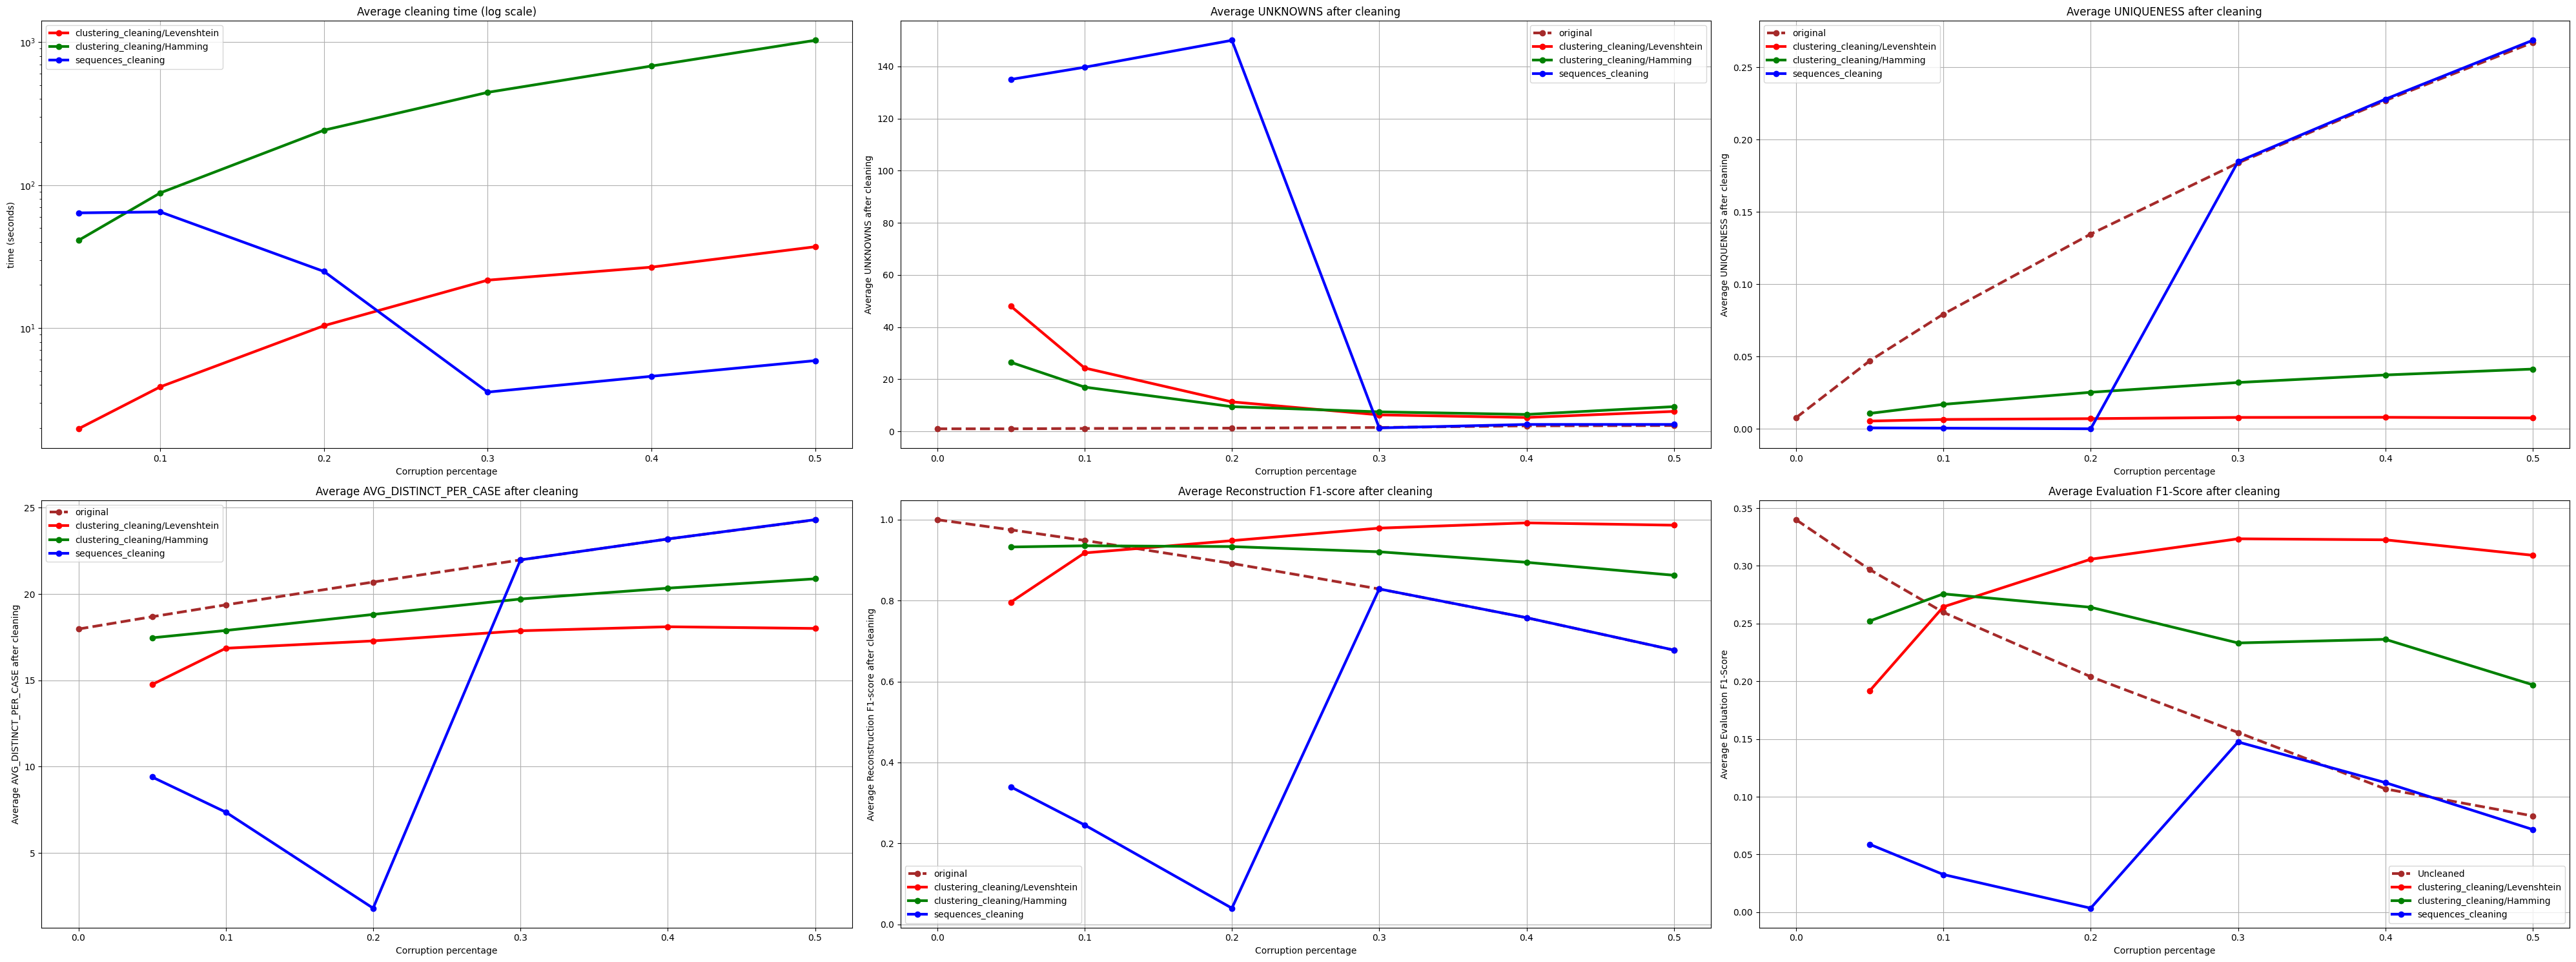

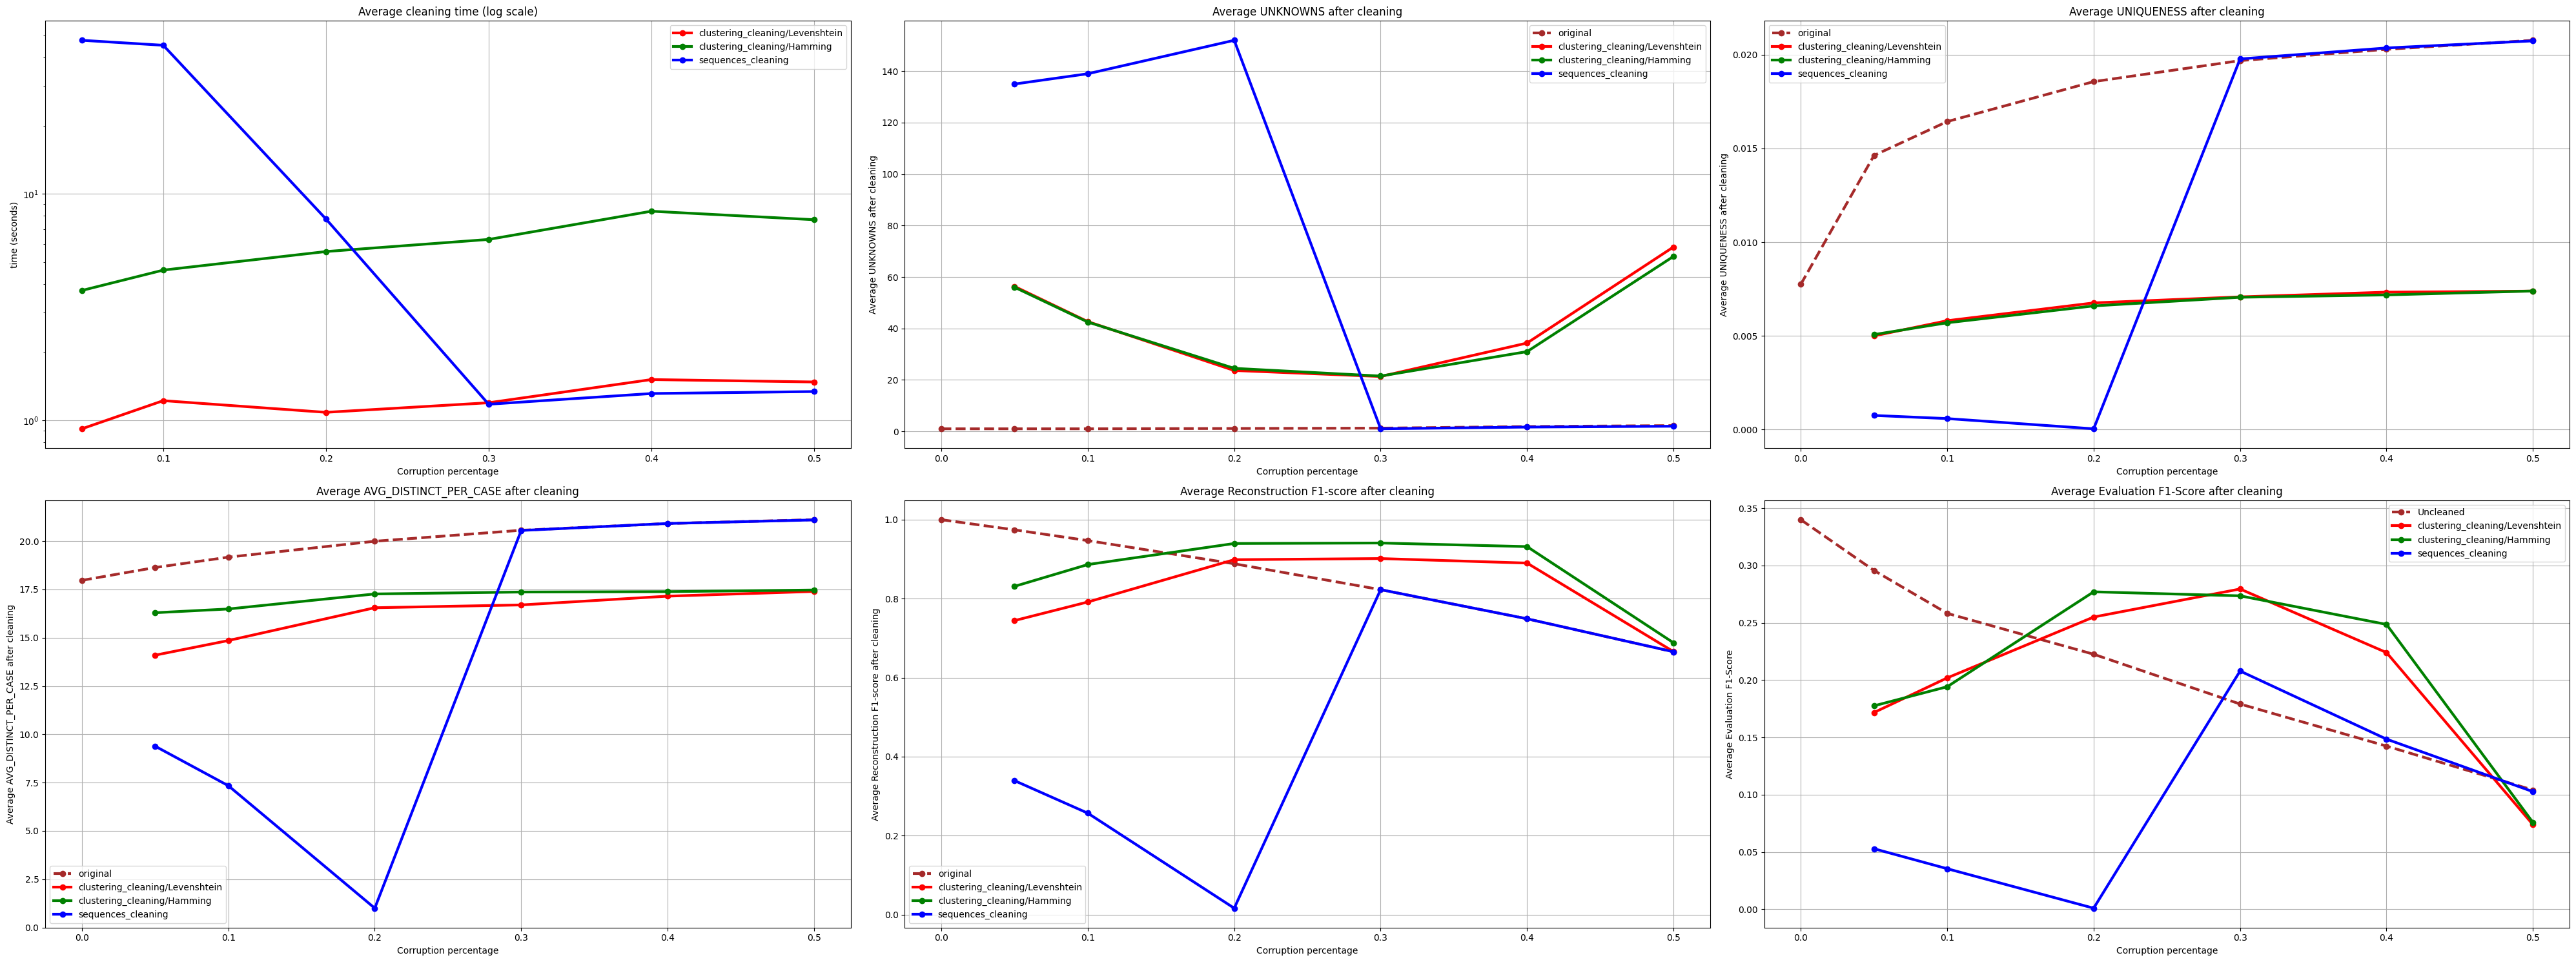

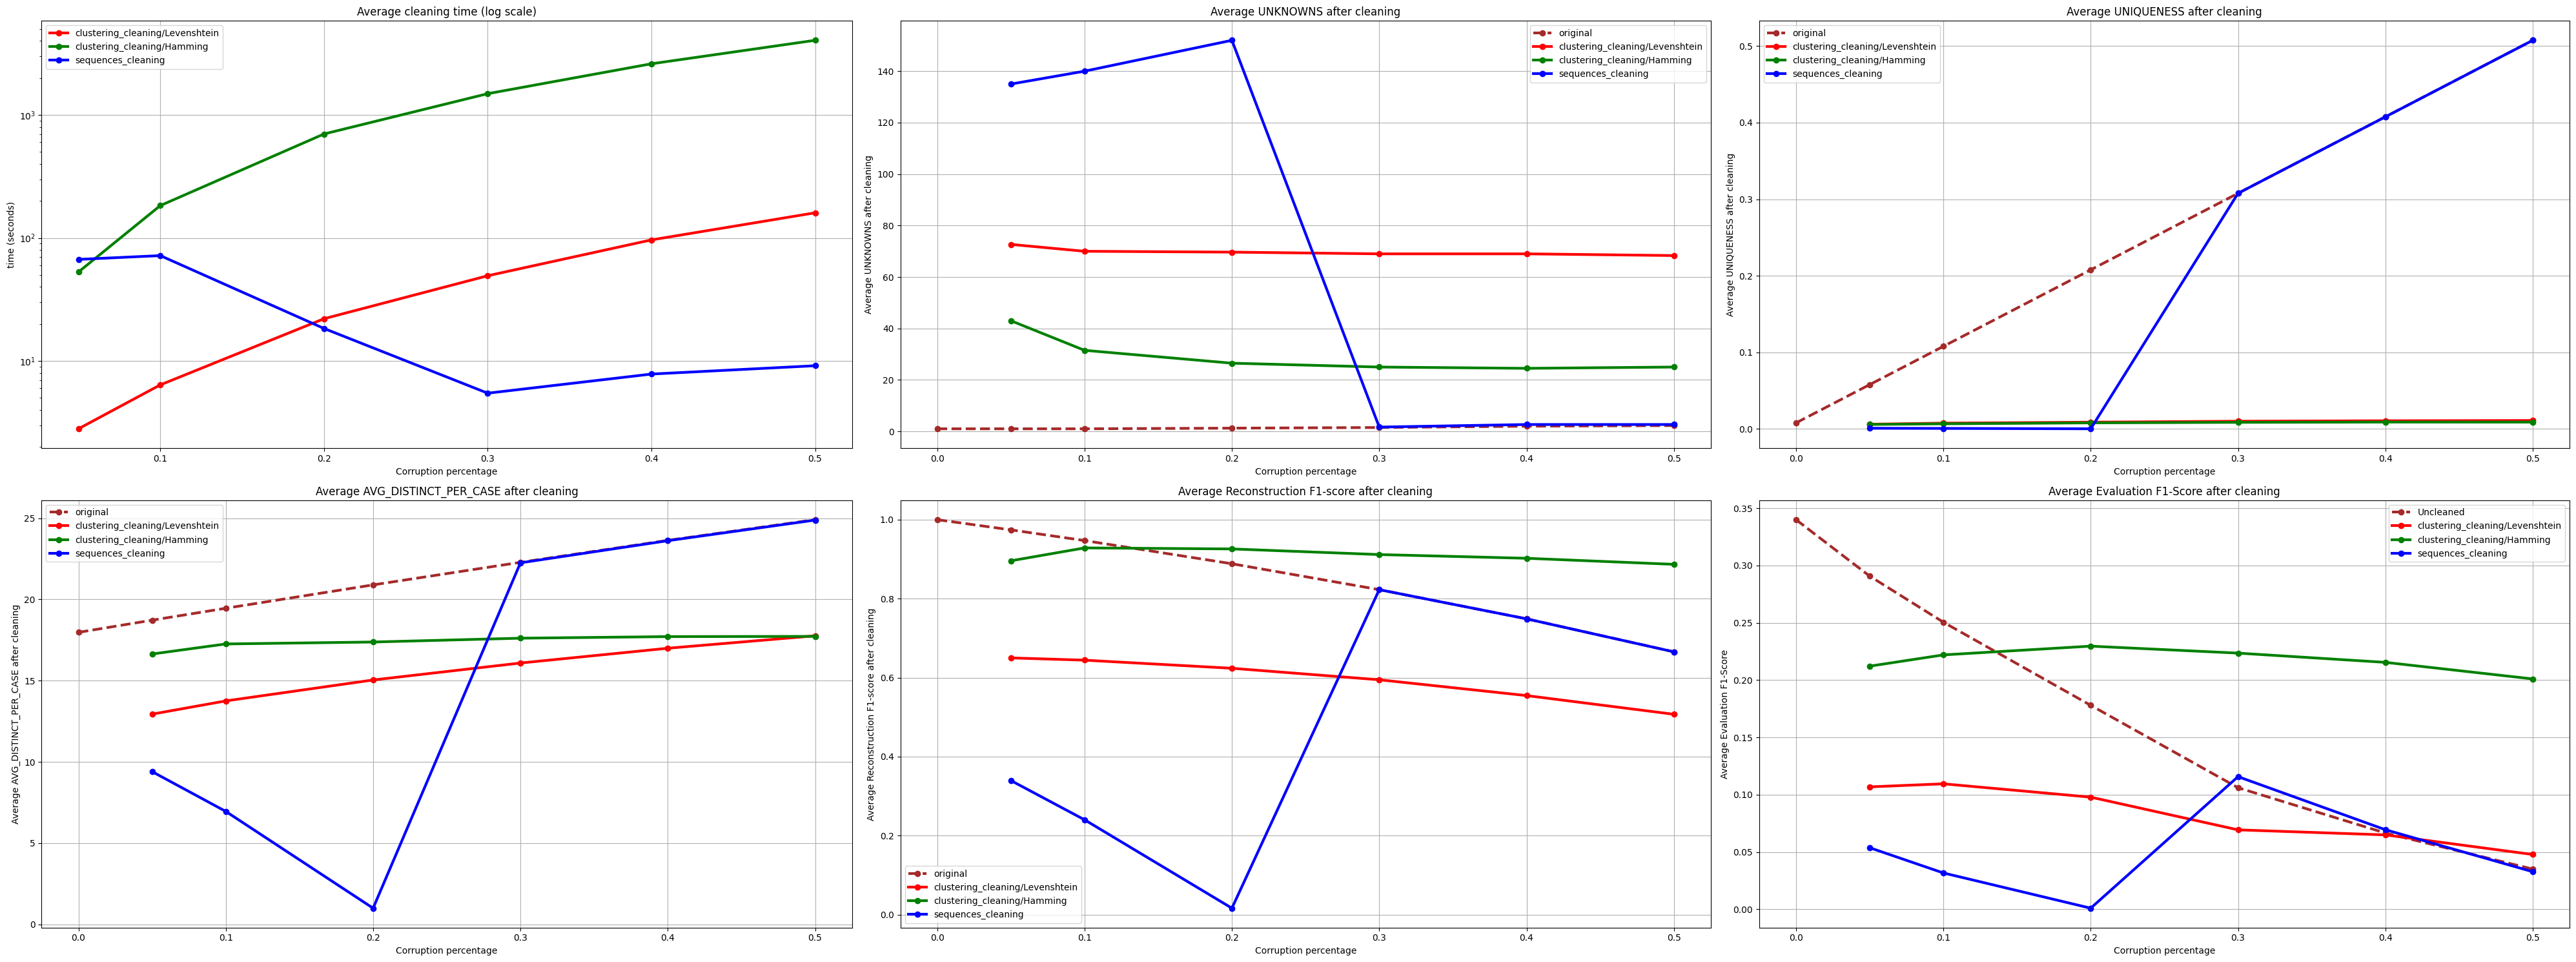

In [ ]:
for pollution_type in pollution_types_1:
  show_compact(dataset, pollution_type)

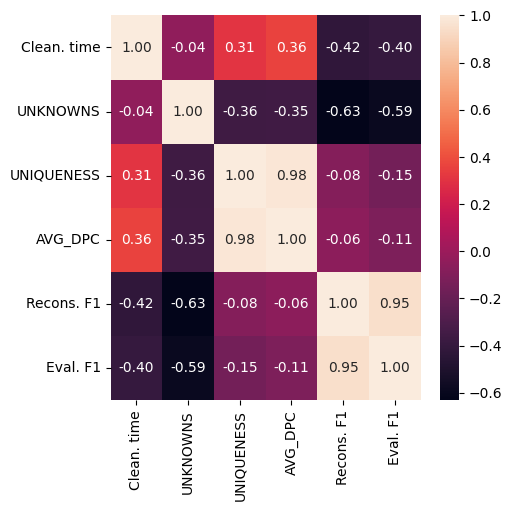

In [ ]:
corr = correlation_analysis(dataset)
plt.figure(figsize=(5,5))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.savefig(f"corr_{dataset2Short[dataset]}.png", bbox_inches='tight')

# BPIC15

In [ ]:
dataset = "BPIC15_1_f2"

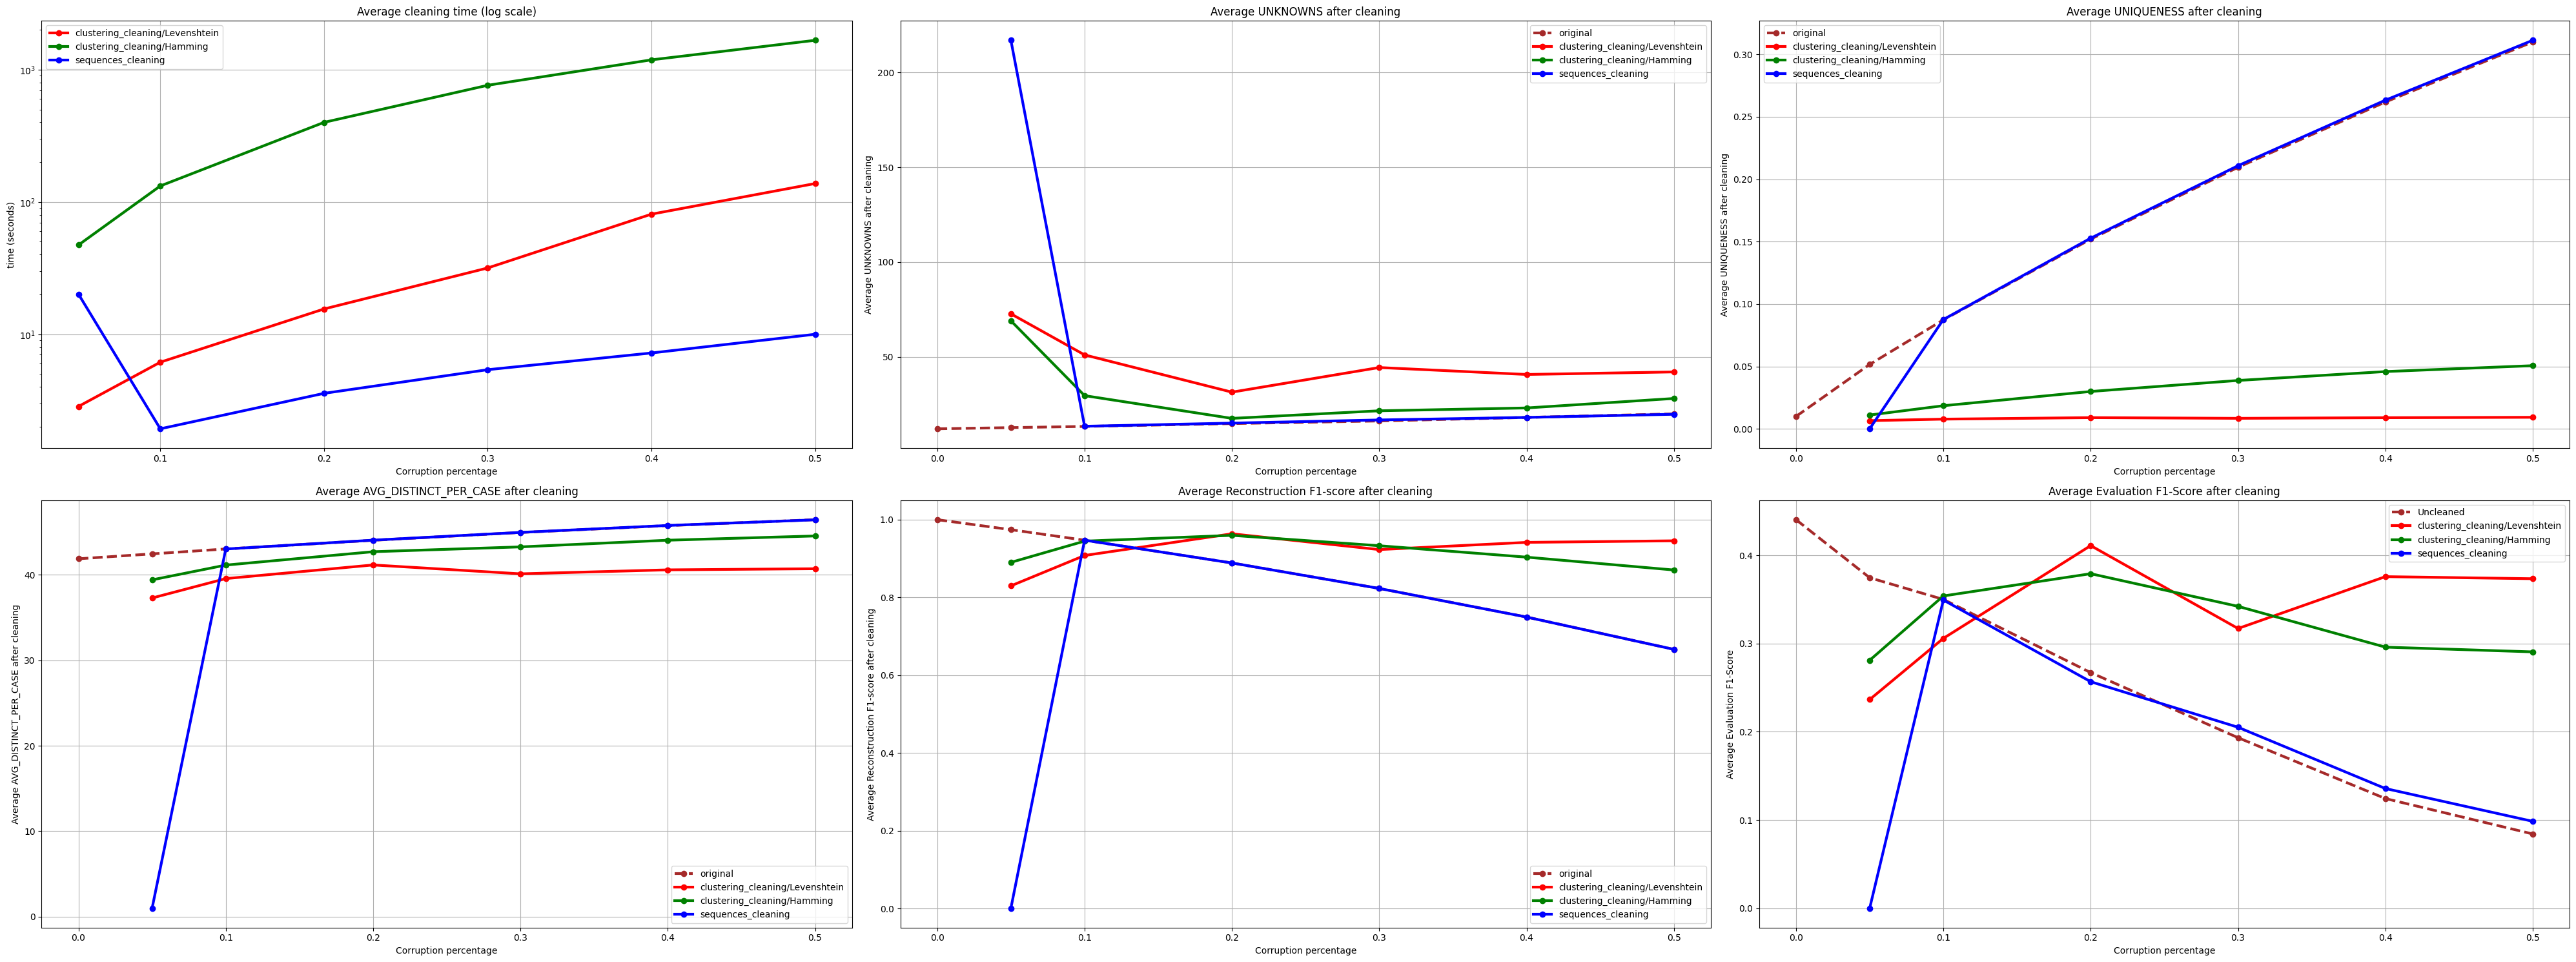

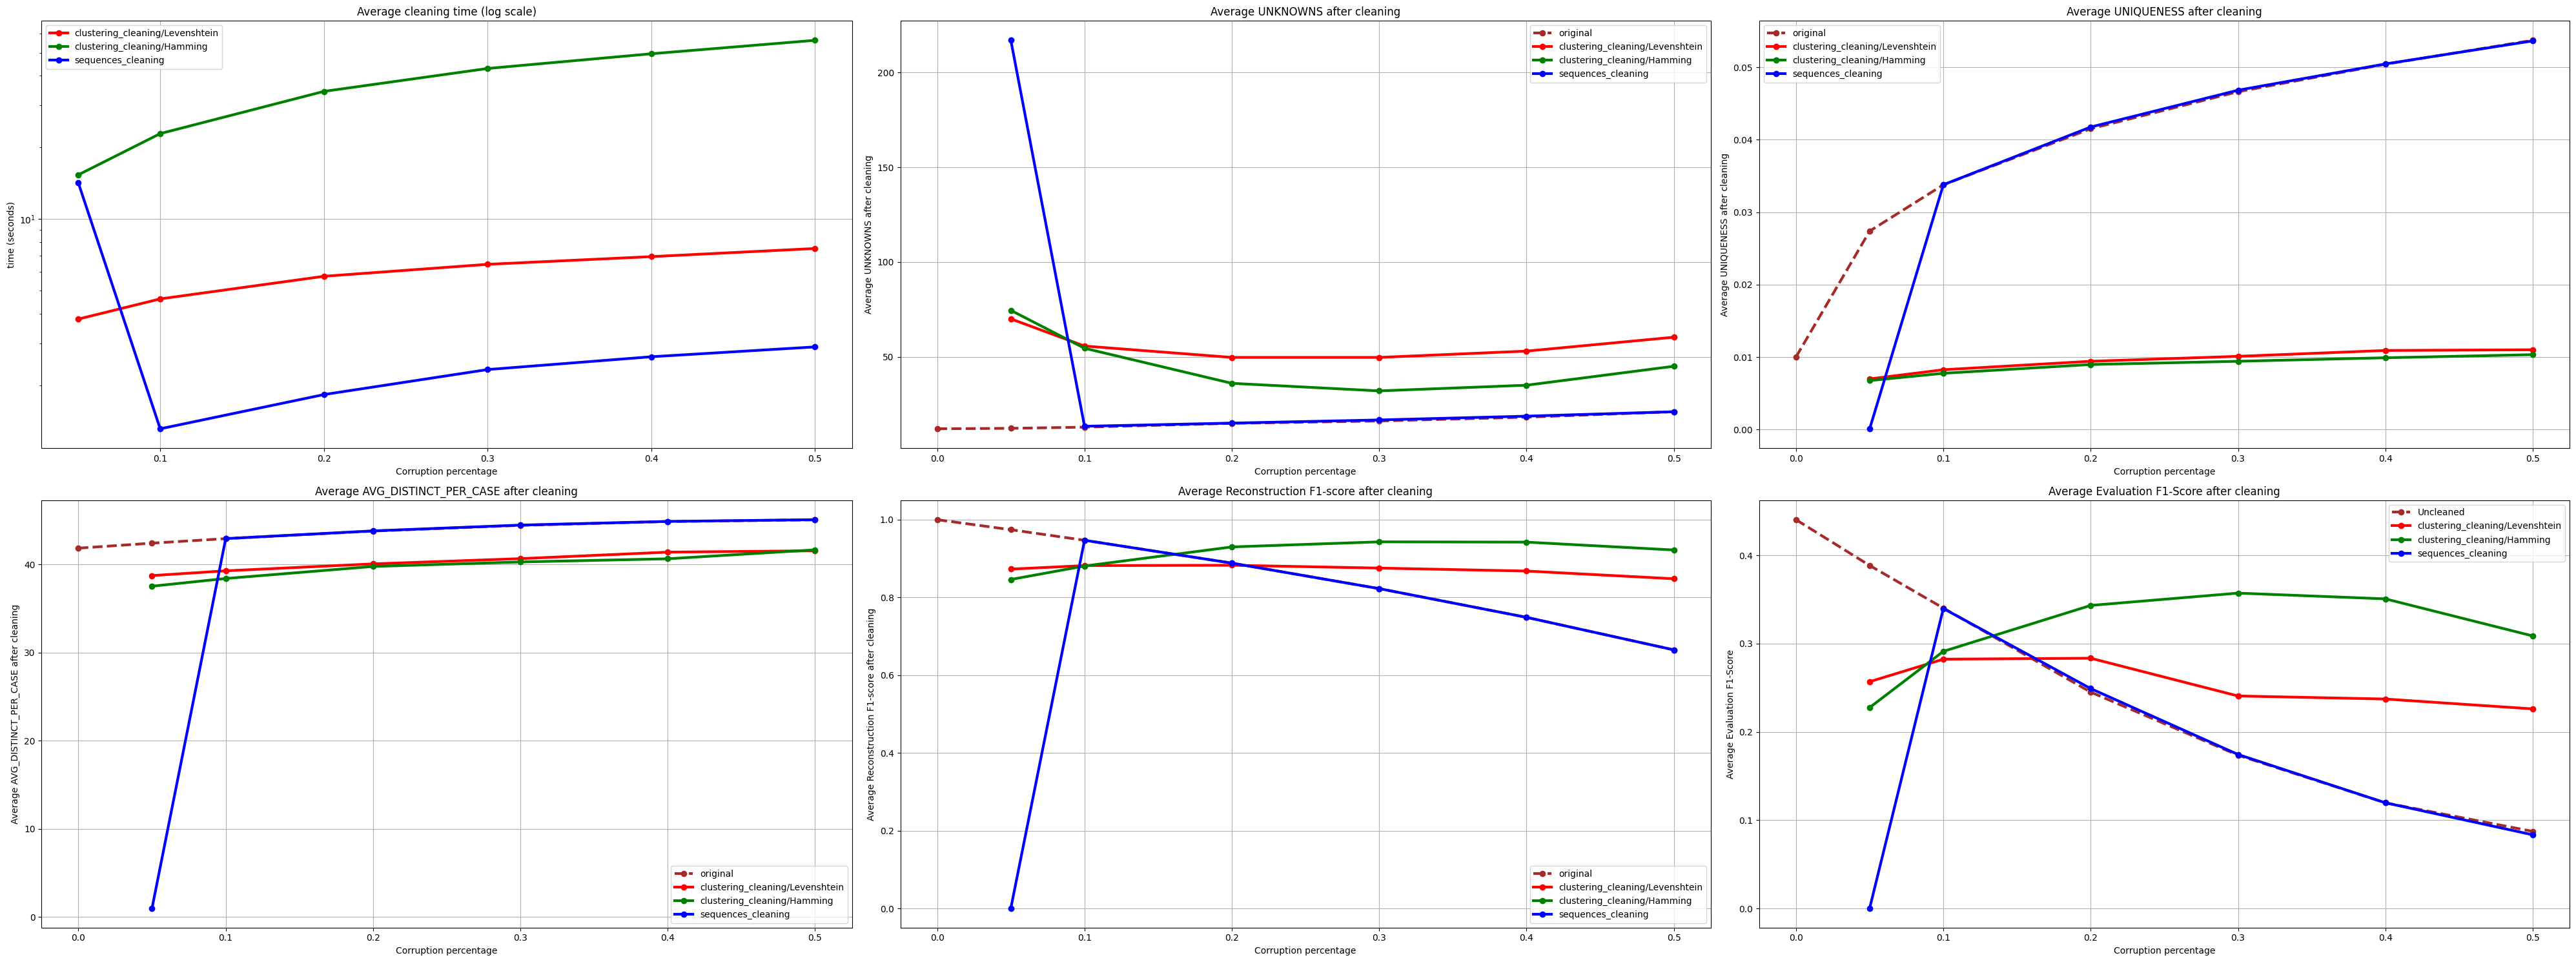

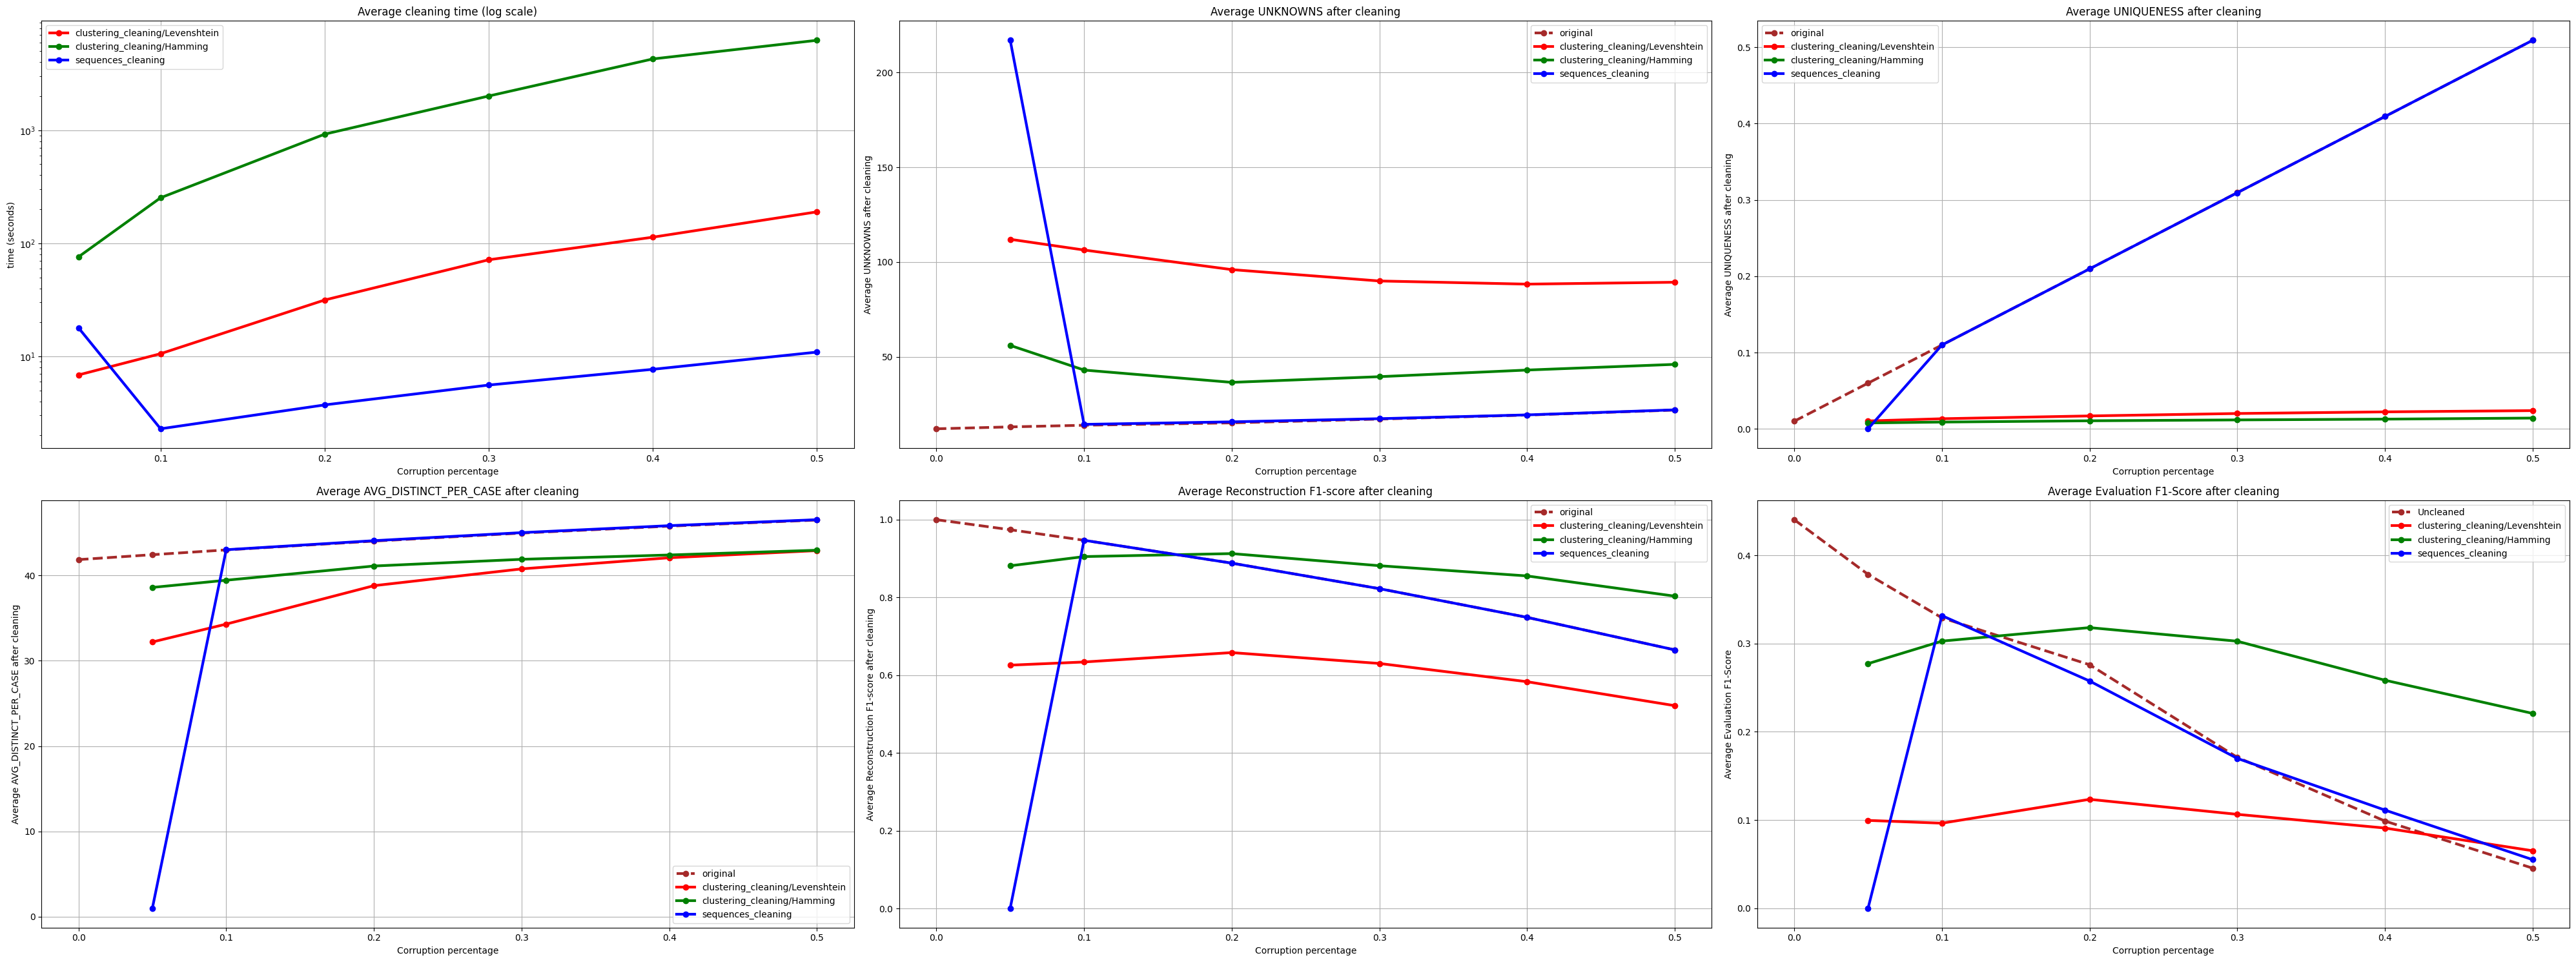

In [ ]:
for pollution_type in pollution_types_1:
  show_compact(dataset, pollution_type)

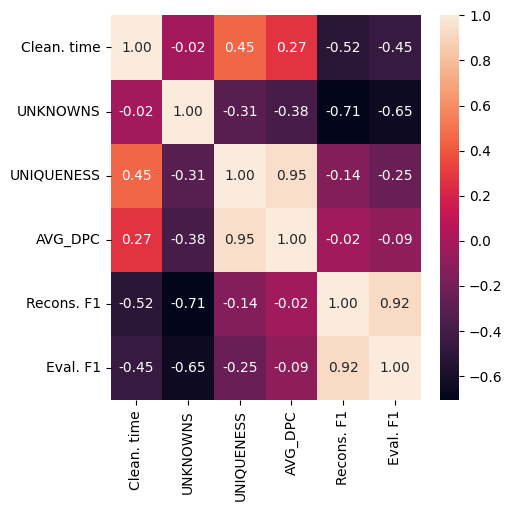

In [ ]:
corr = correlation_analysis(dataset)
plt.figure(figsize=(5,5))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.savefig(f"corr_{dataset2Short[dataset]}.png", bbox_inches='tight')

# Credit

In [ ]:
dataset = "Credit"

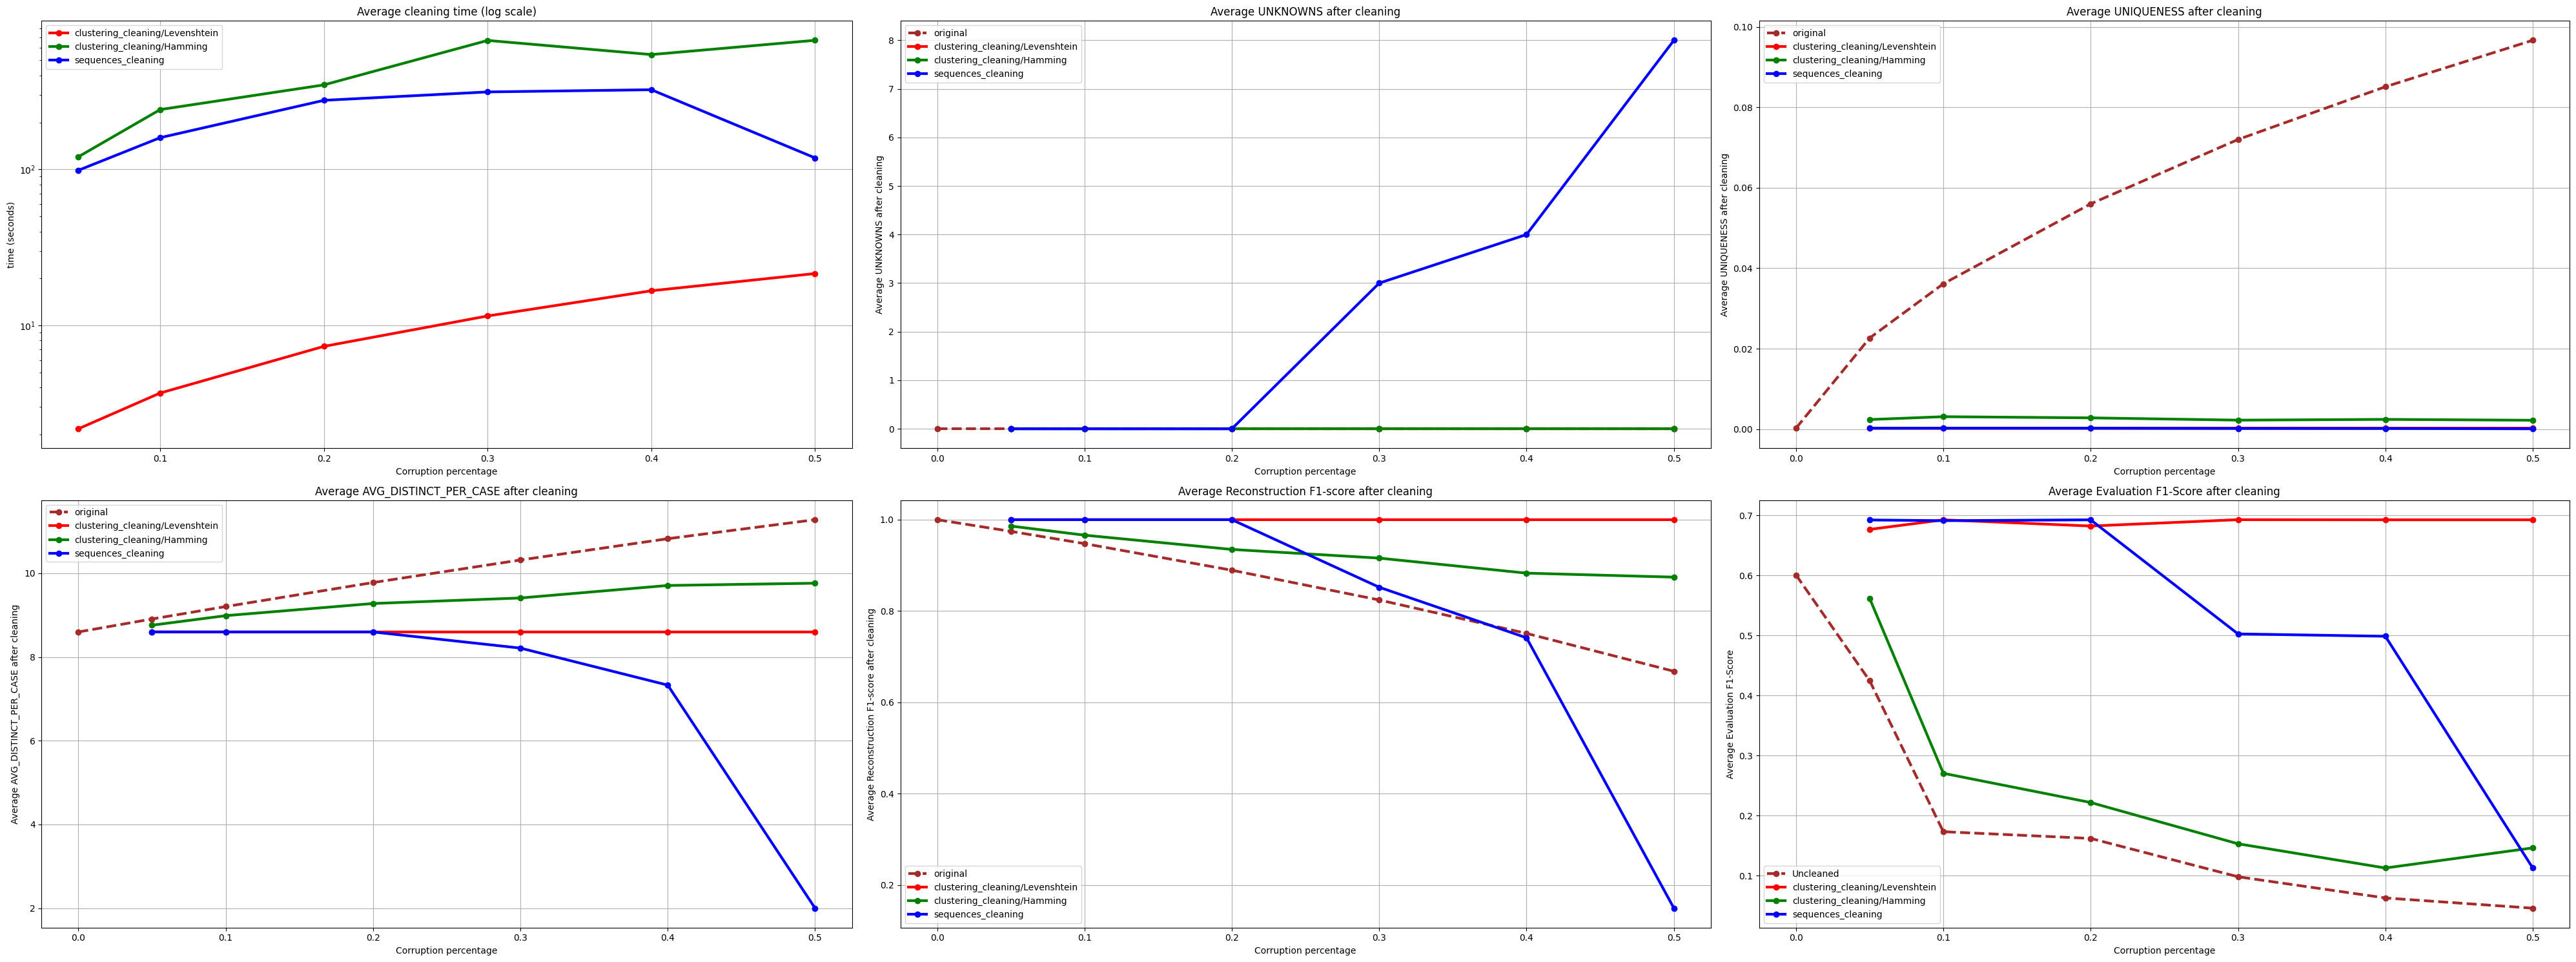

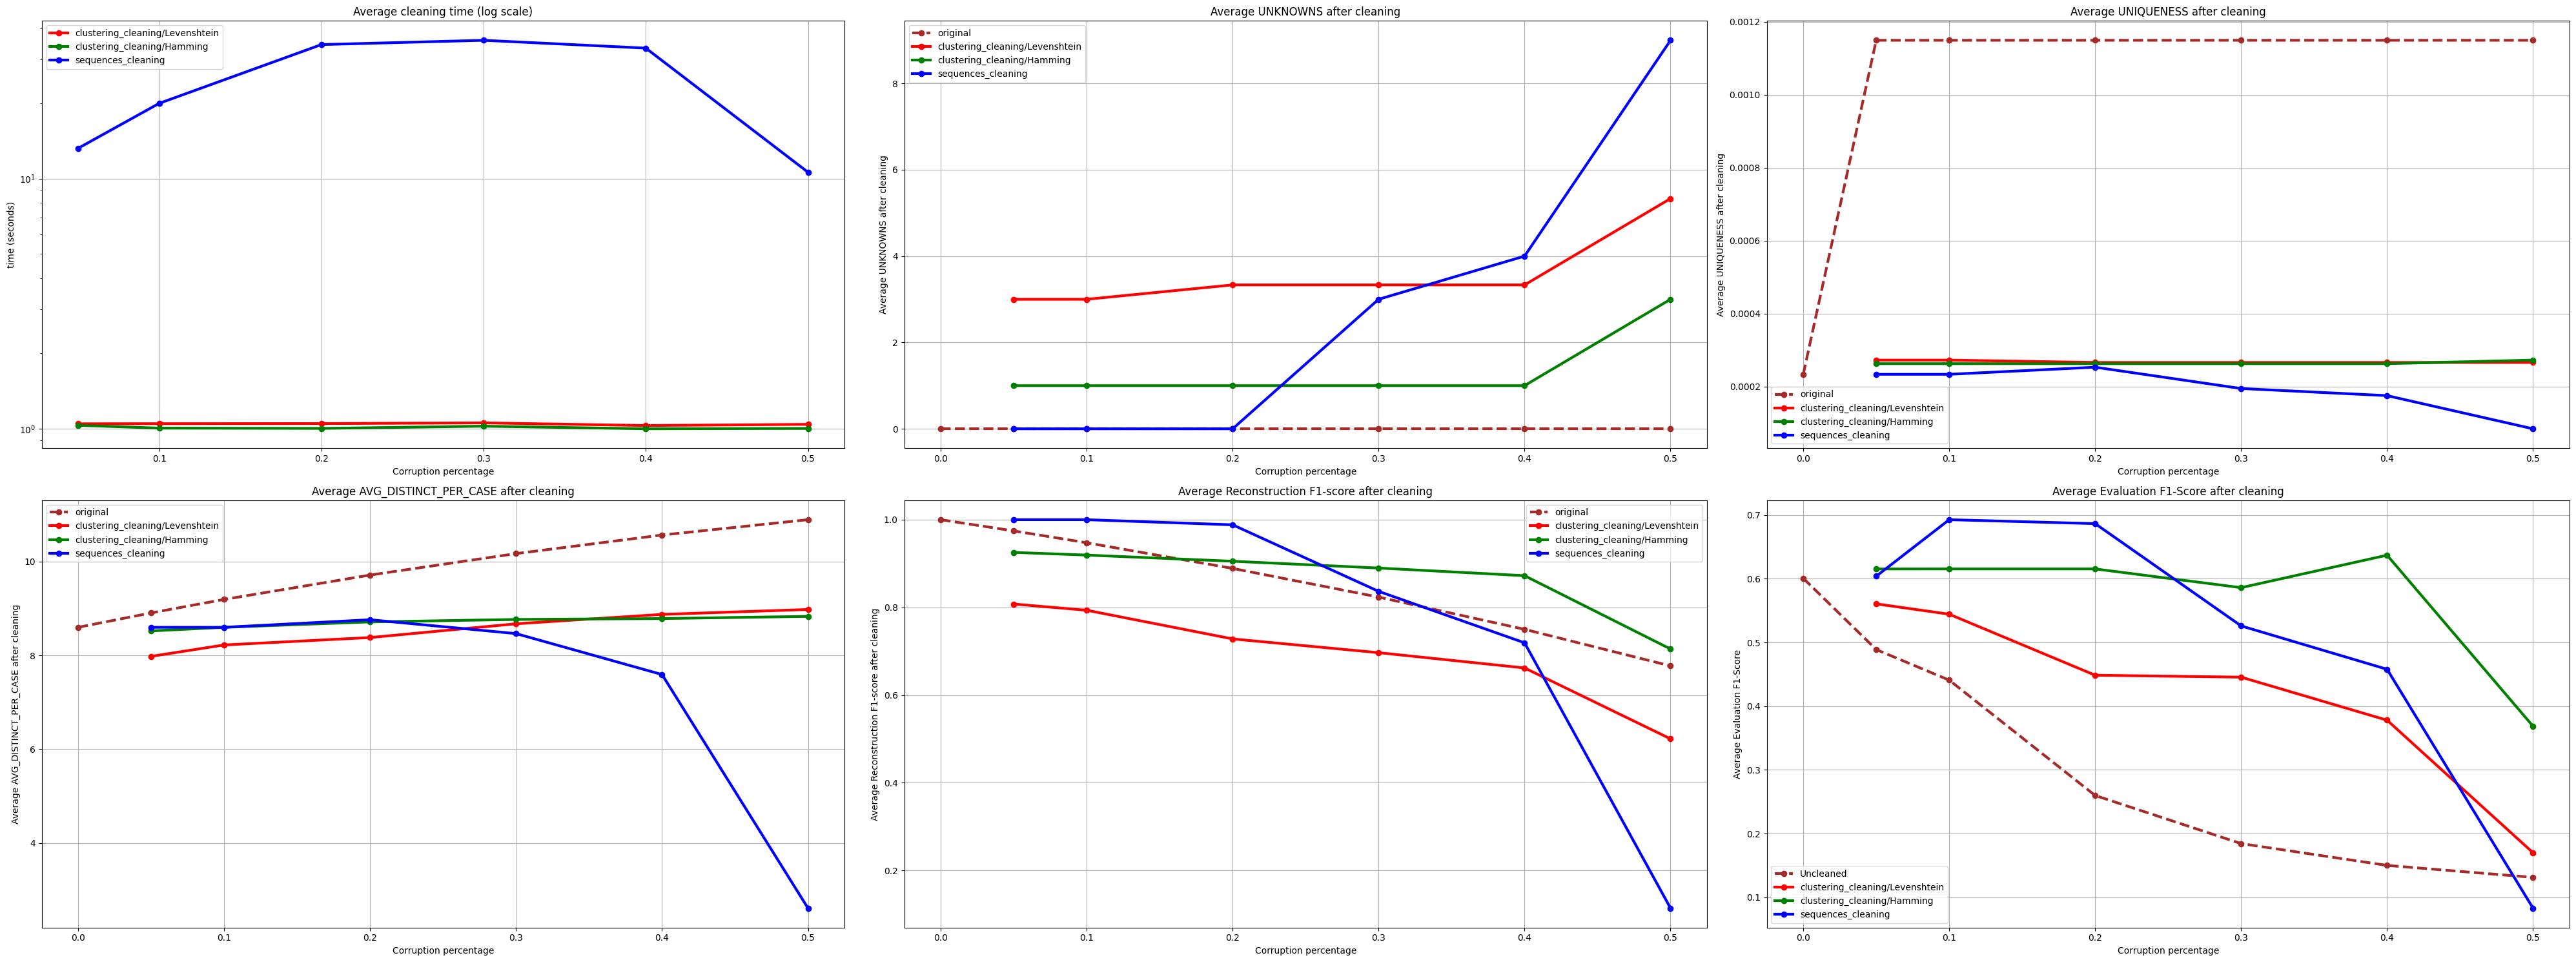

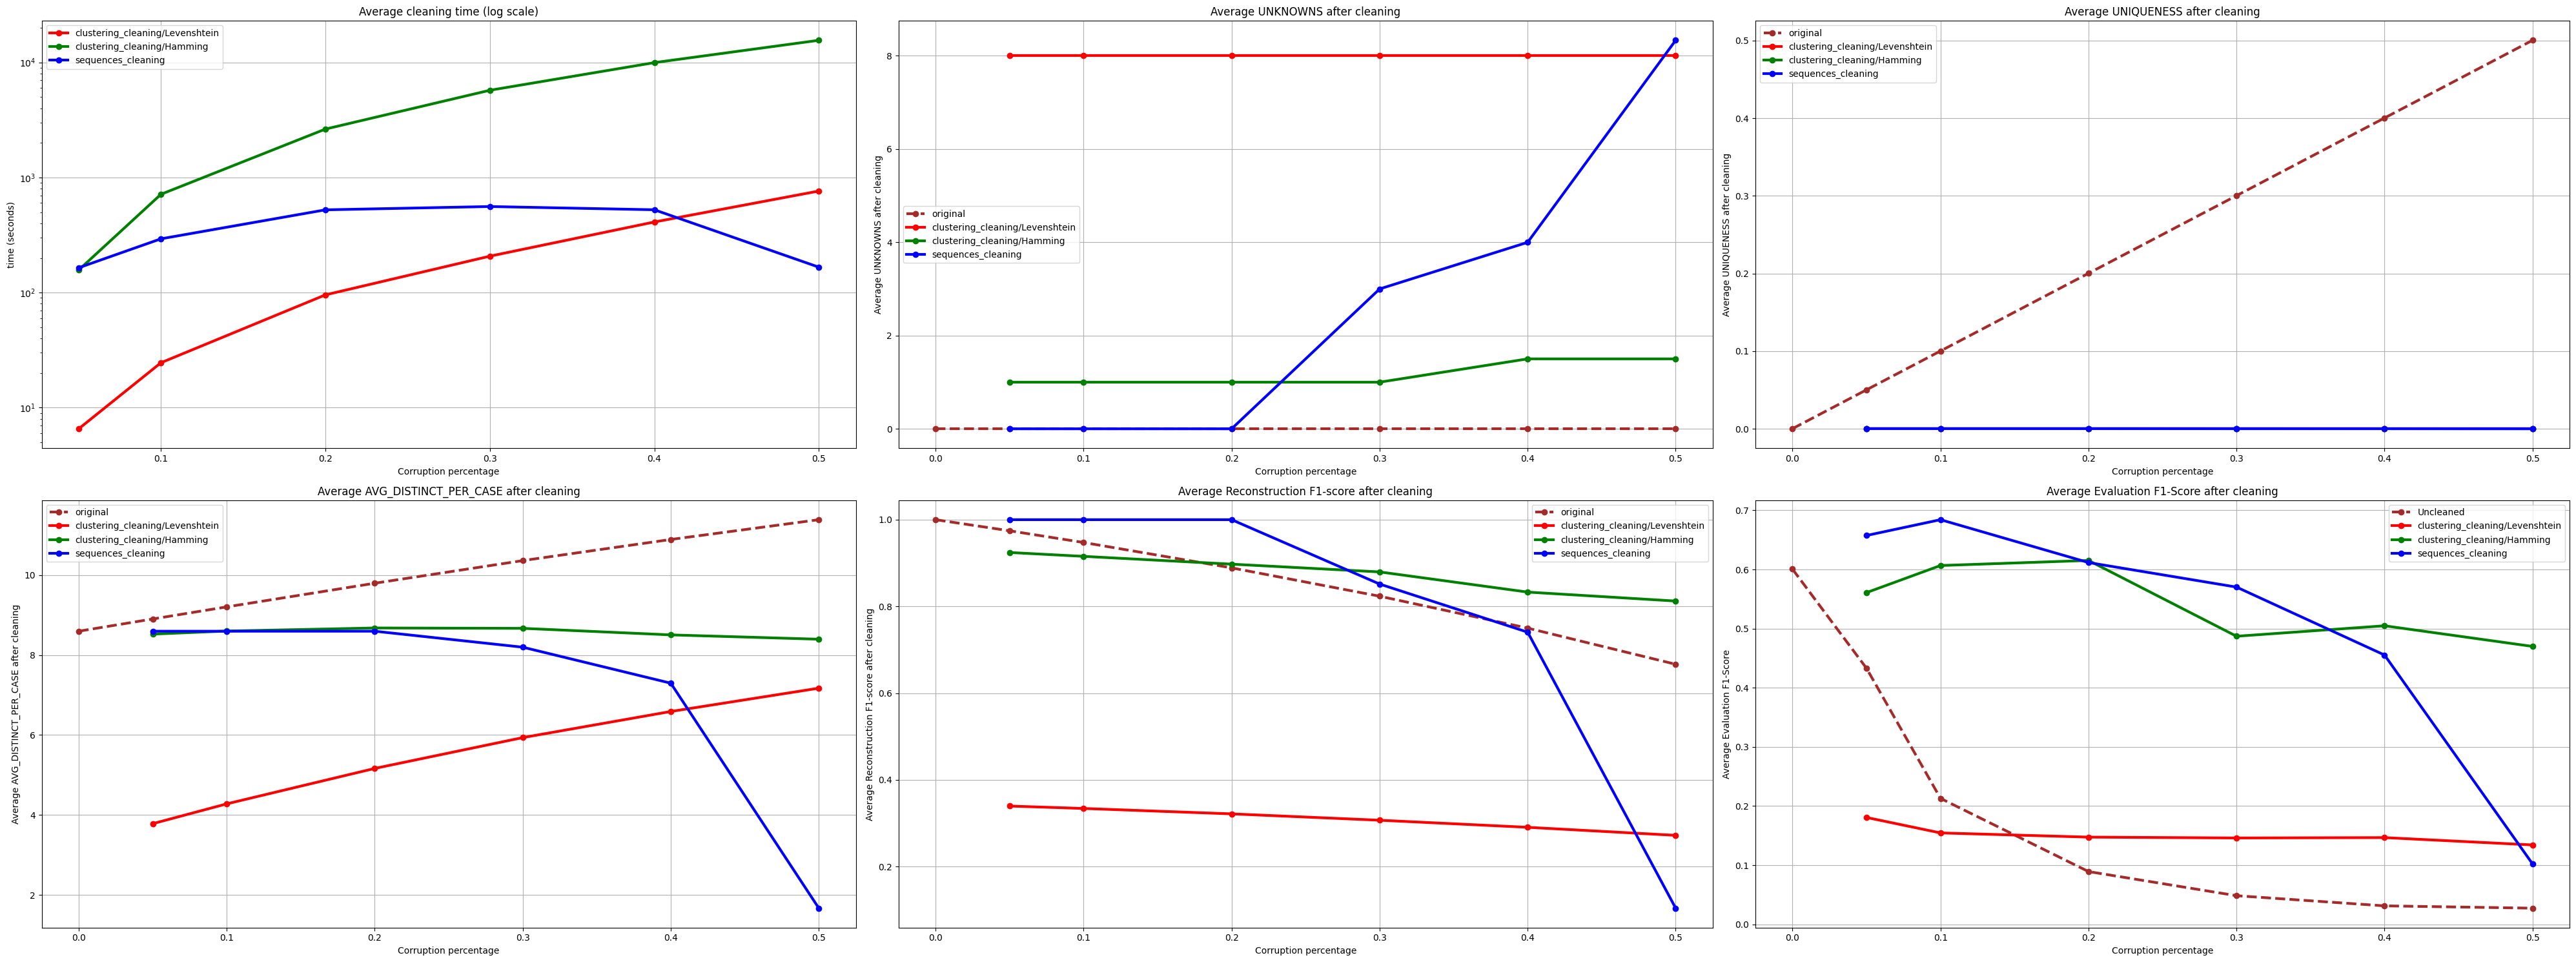

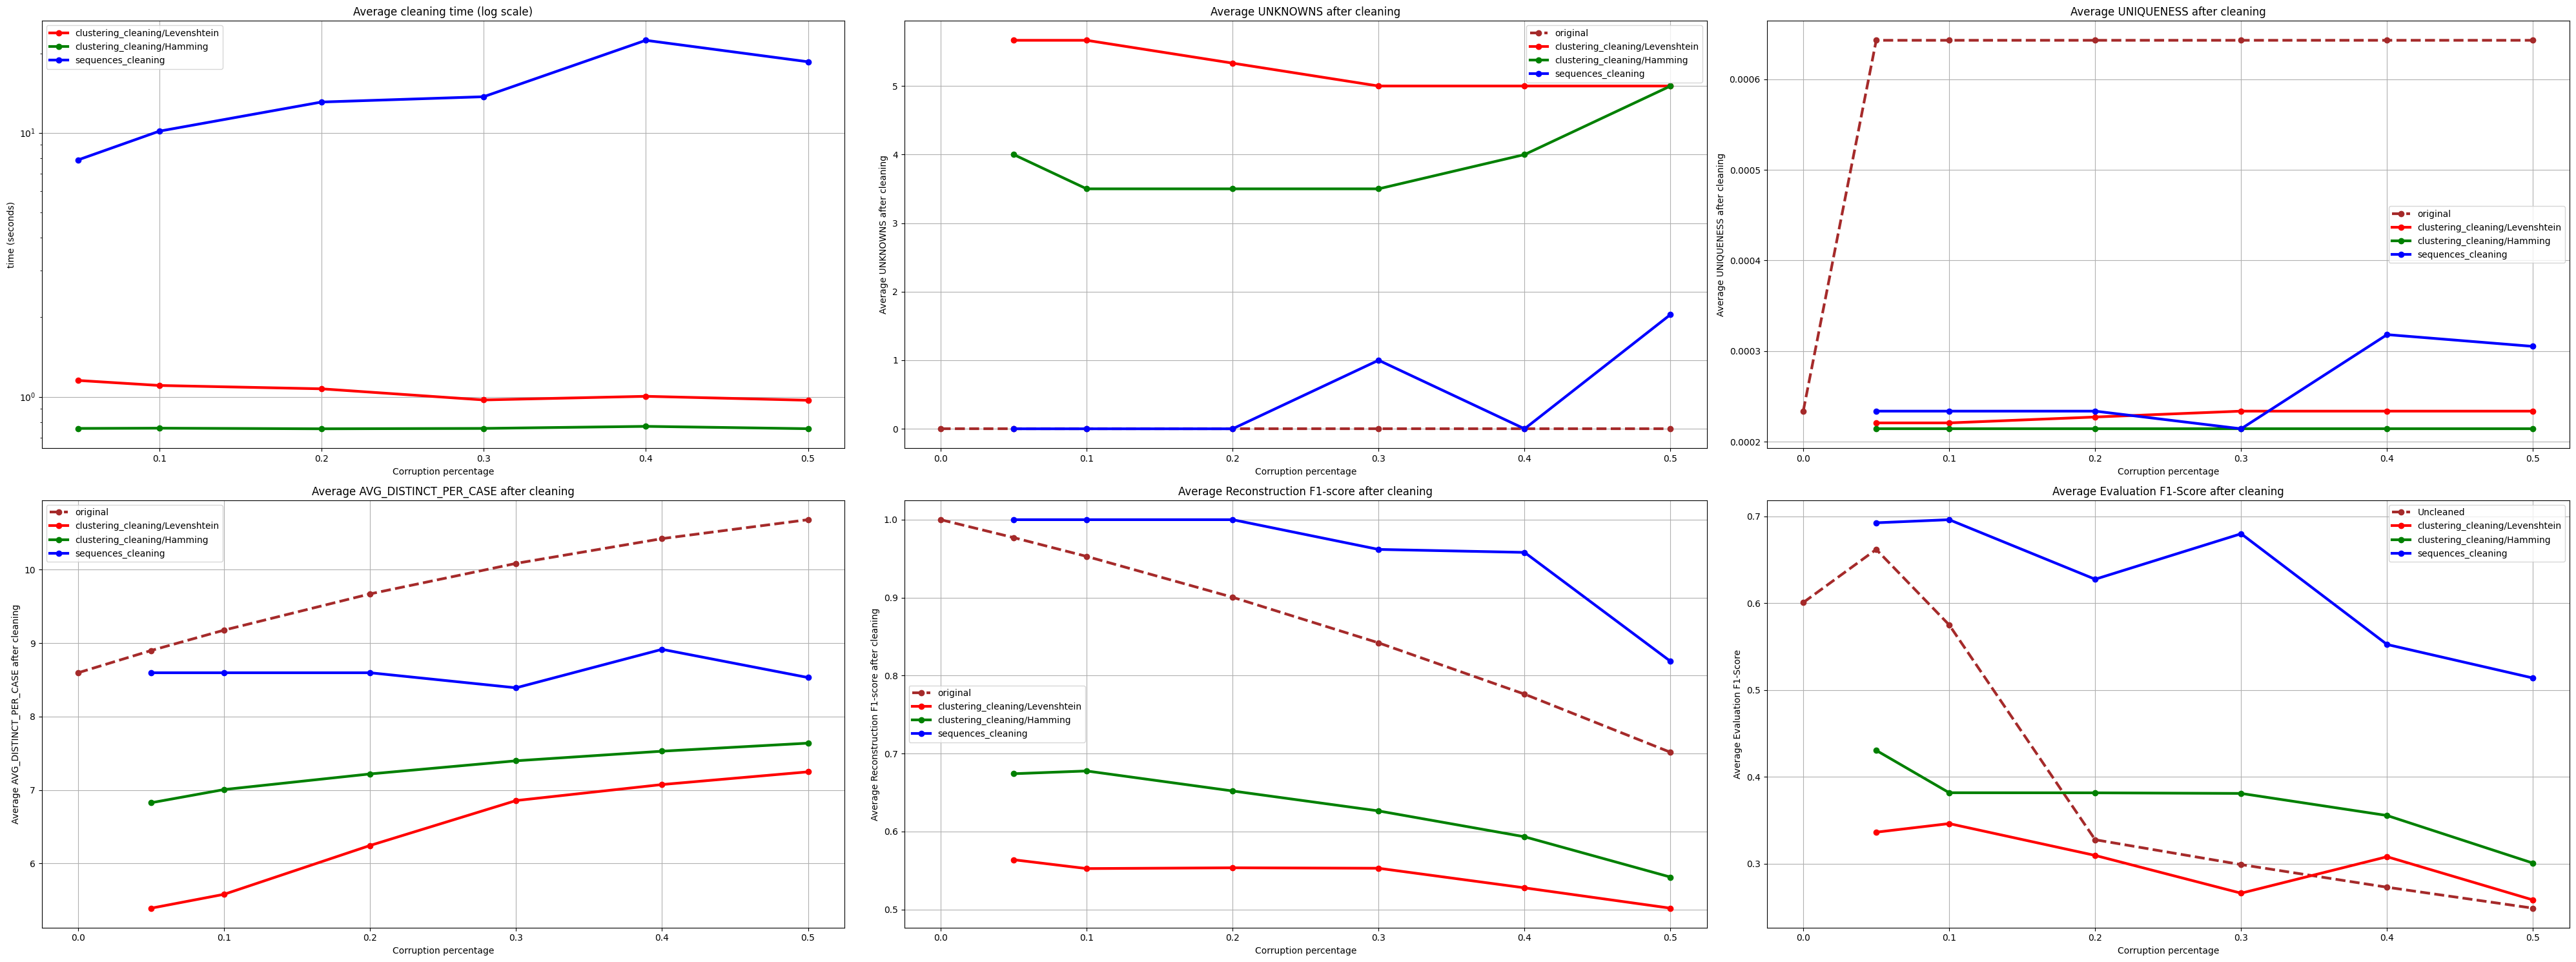

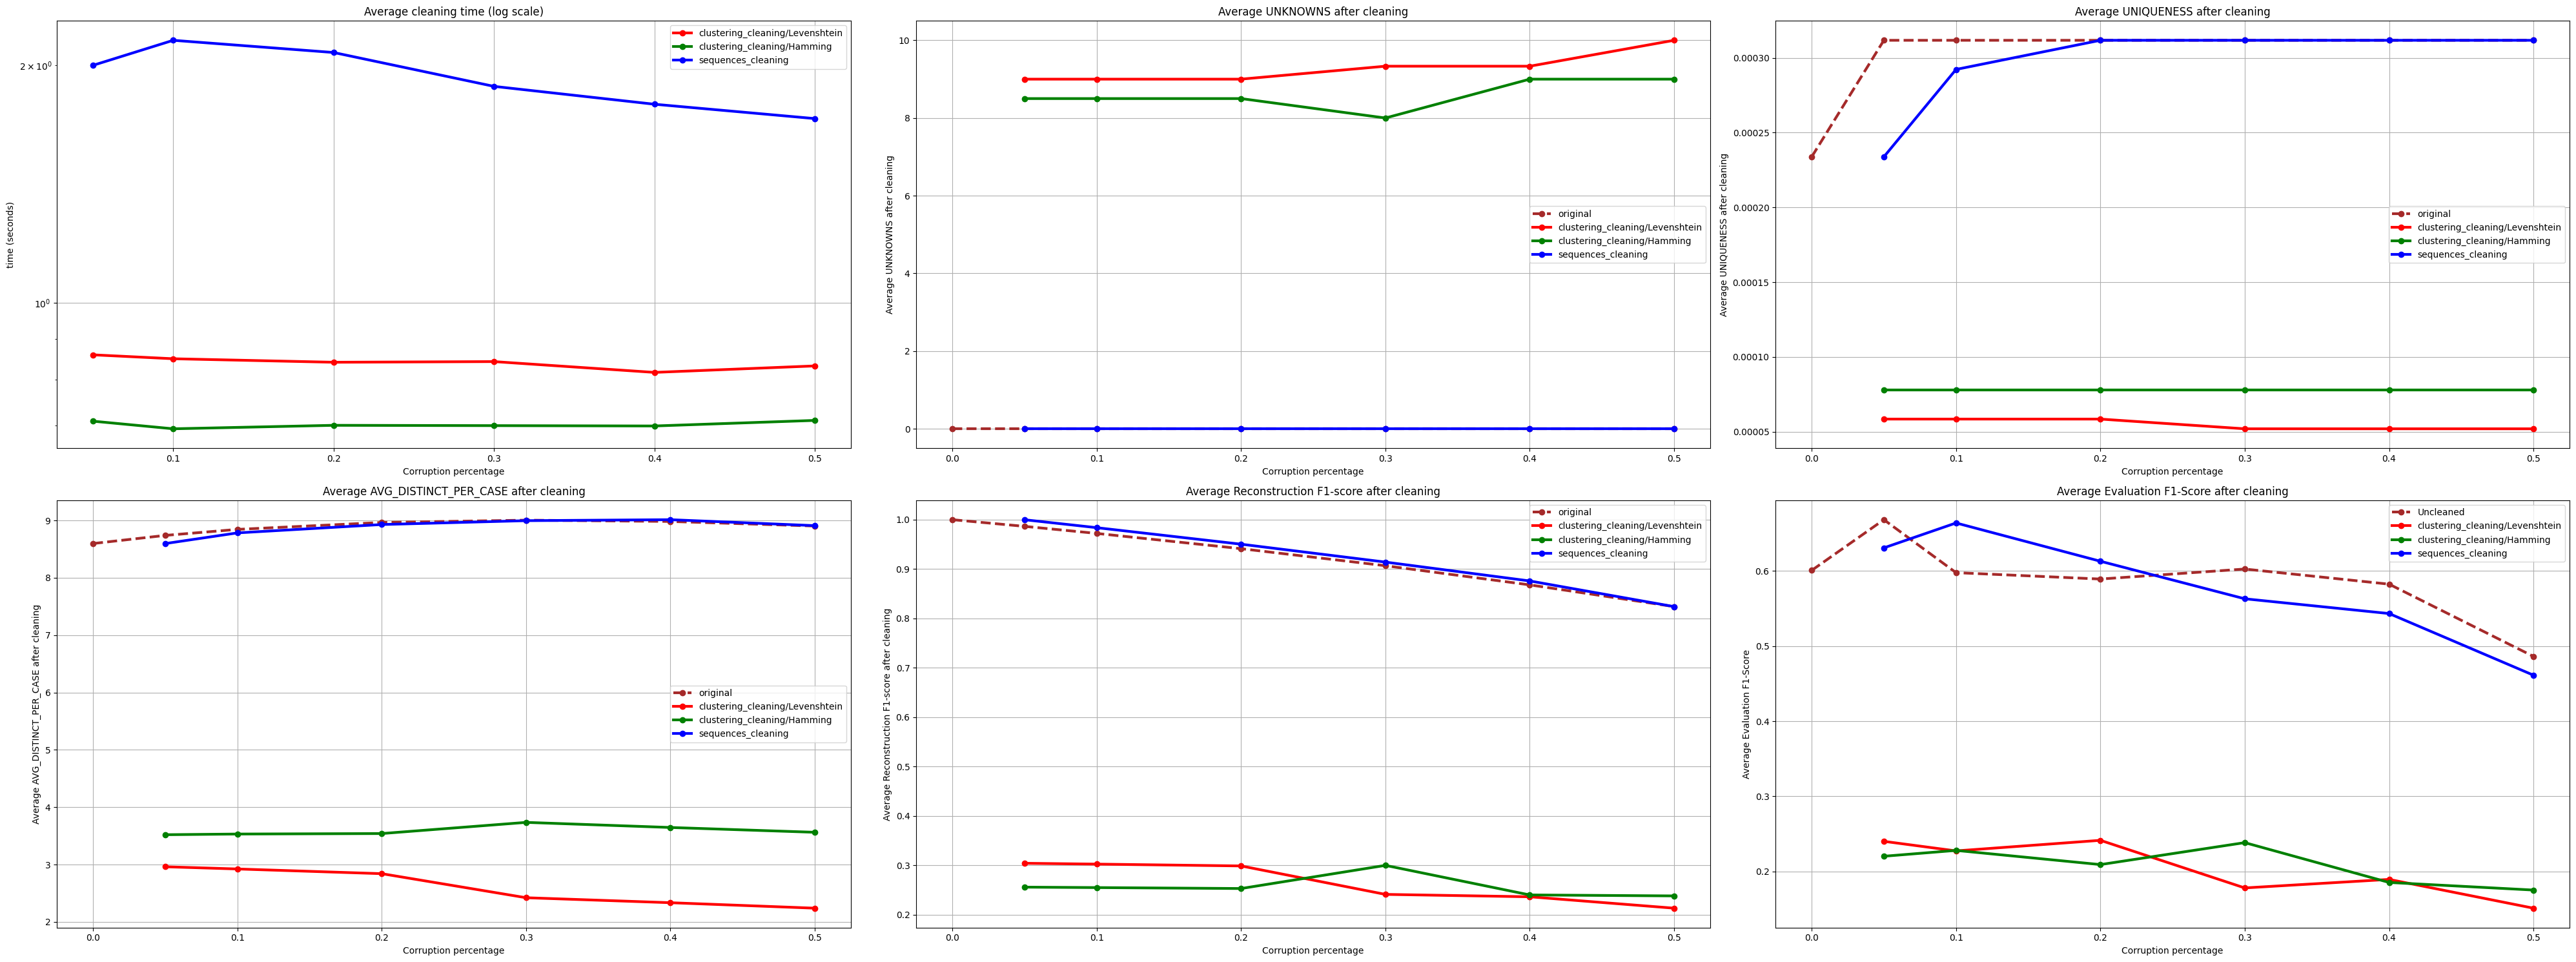

In [ ]:
for pollution_type in pollution_types_2:
  show_compact(dataset, pollution_type)

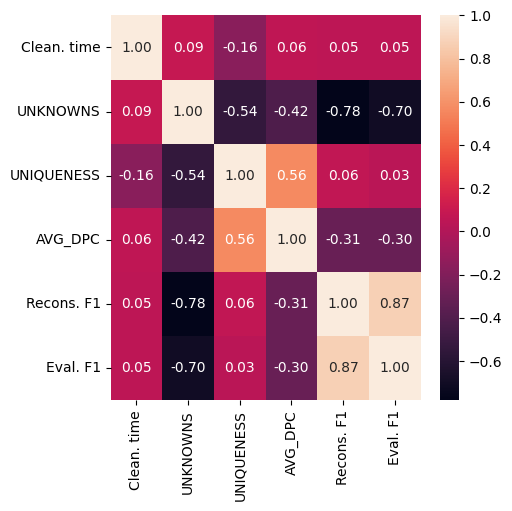

In [ ]:
corr = correlation_analysis(dataset)
plt.figure(figsize=(5,5))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.savefig(f"corr_{dataset2Short[dataset]}.png", bbox_inches='tight')

# Pub

In [ ]:
dataset = "Pub"

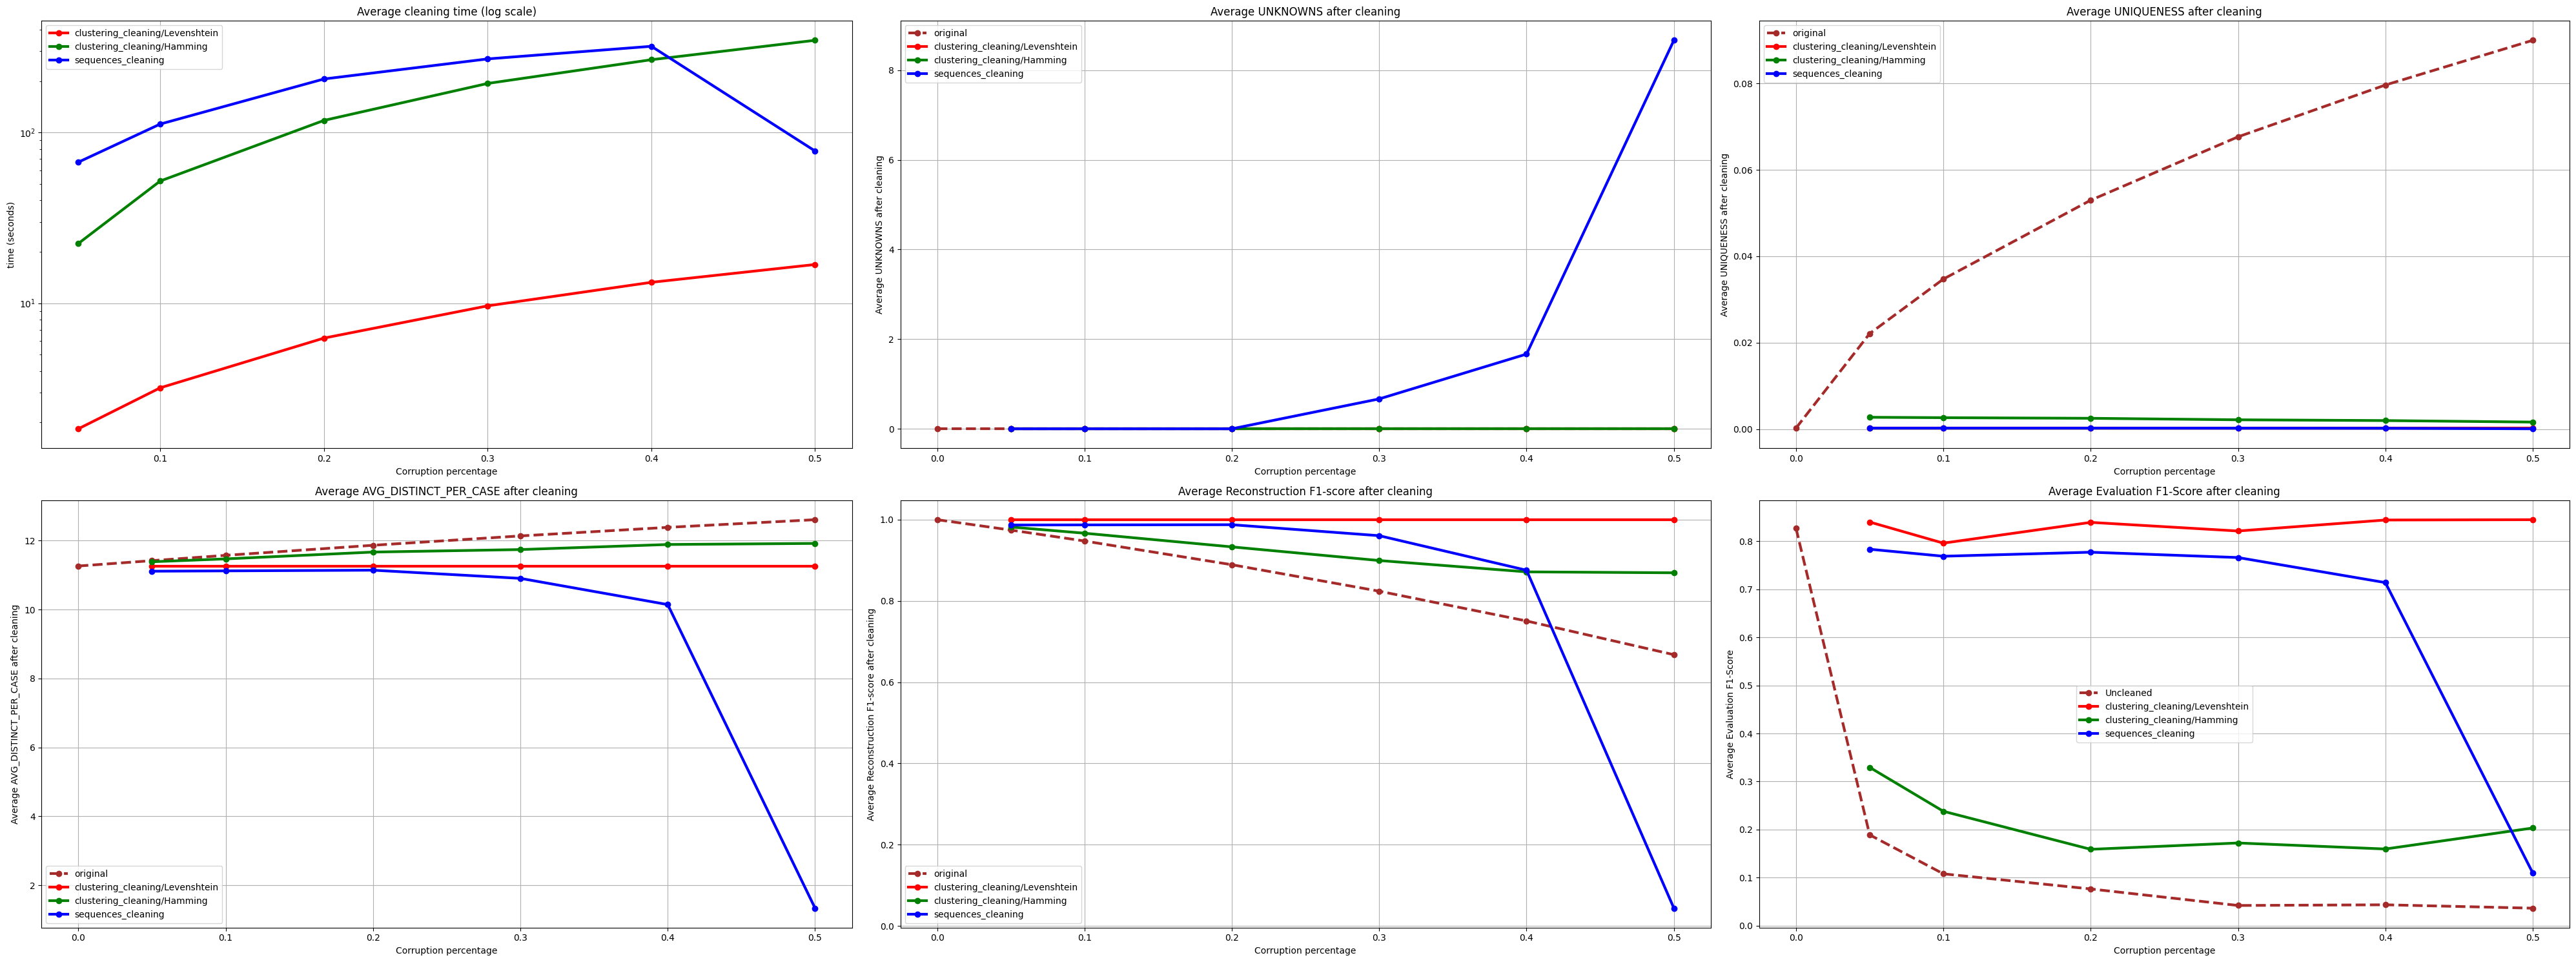

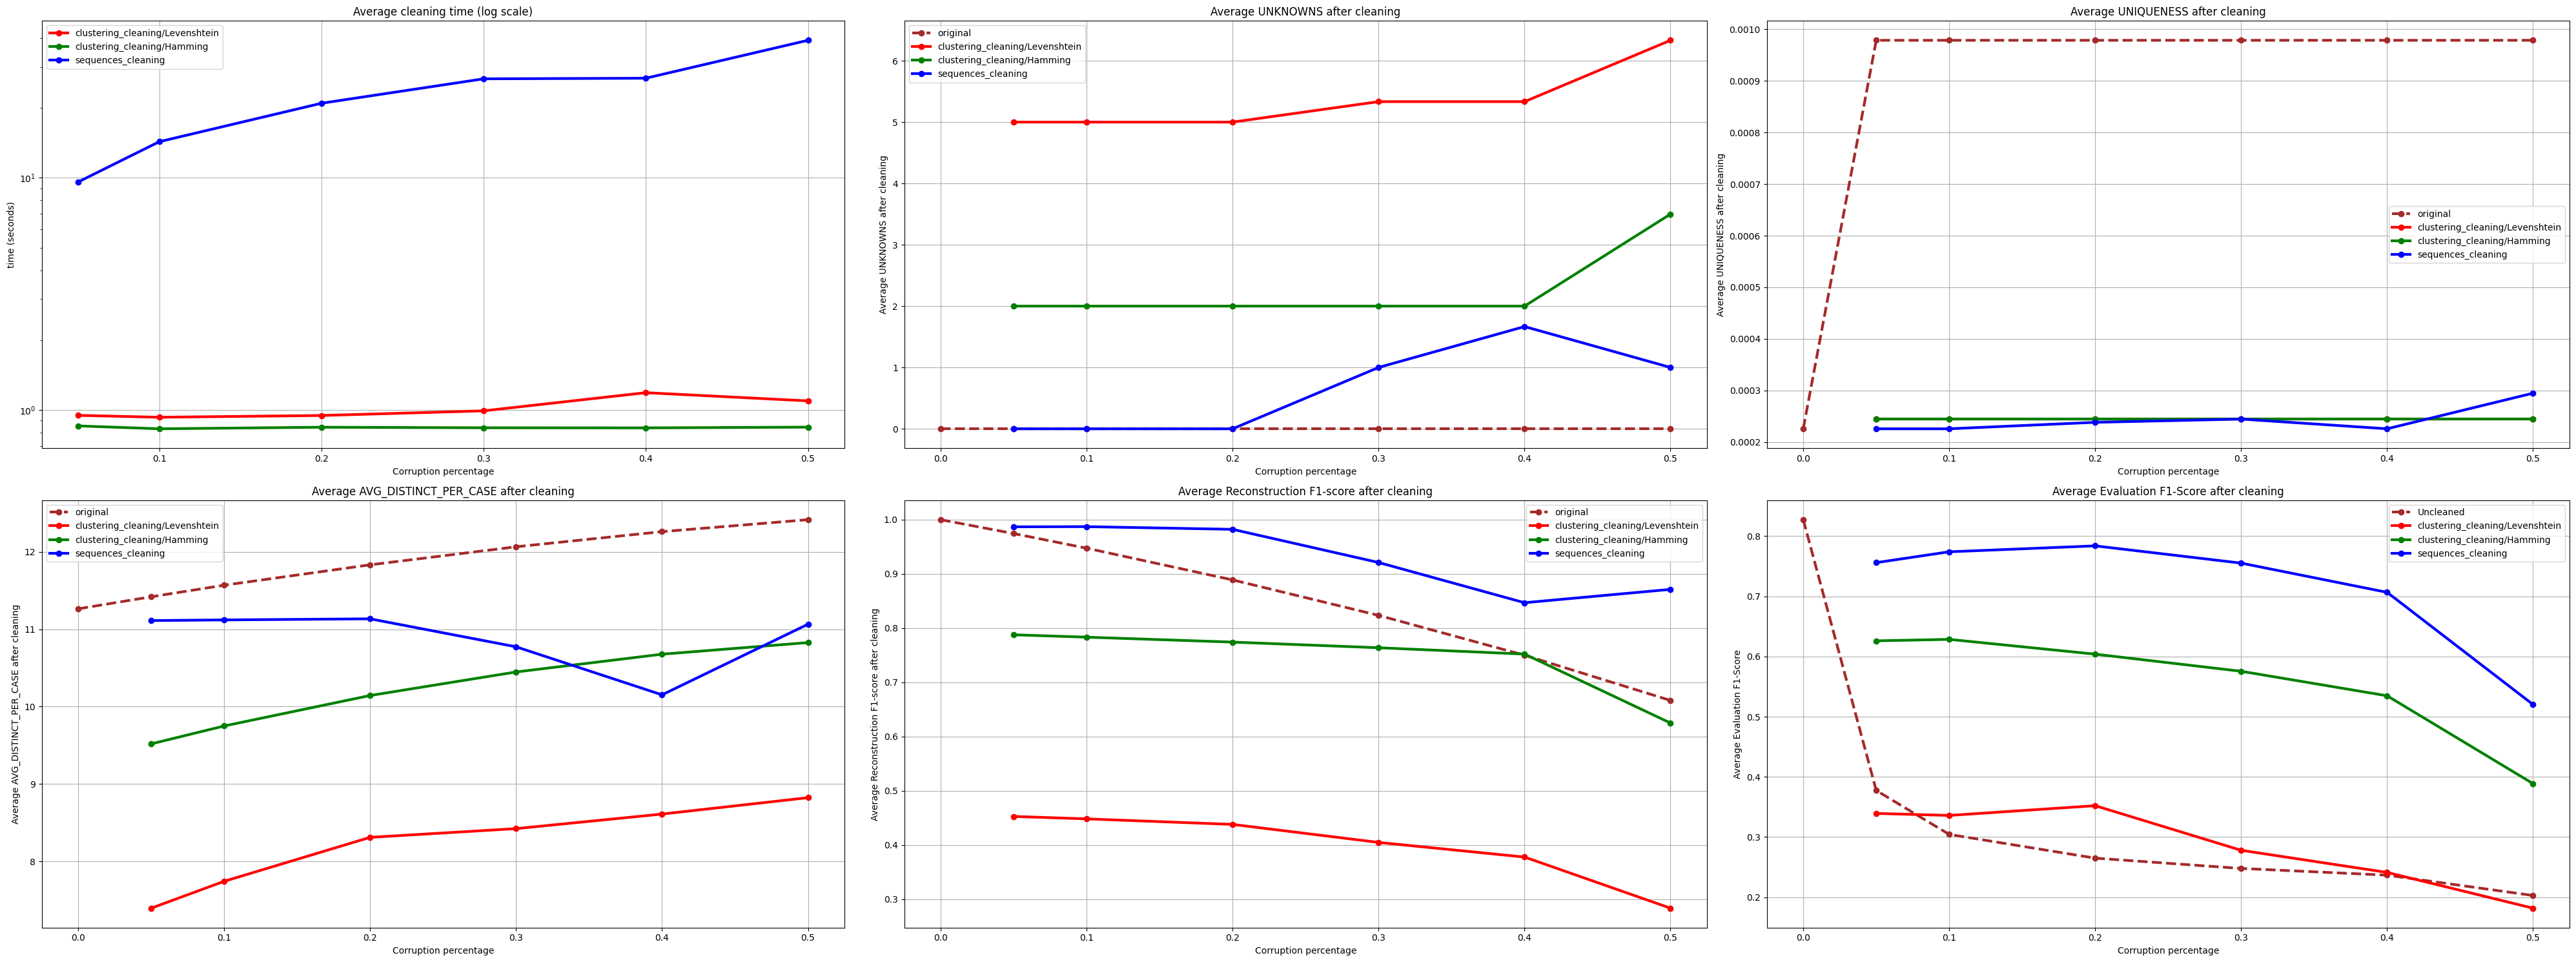

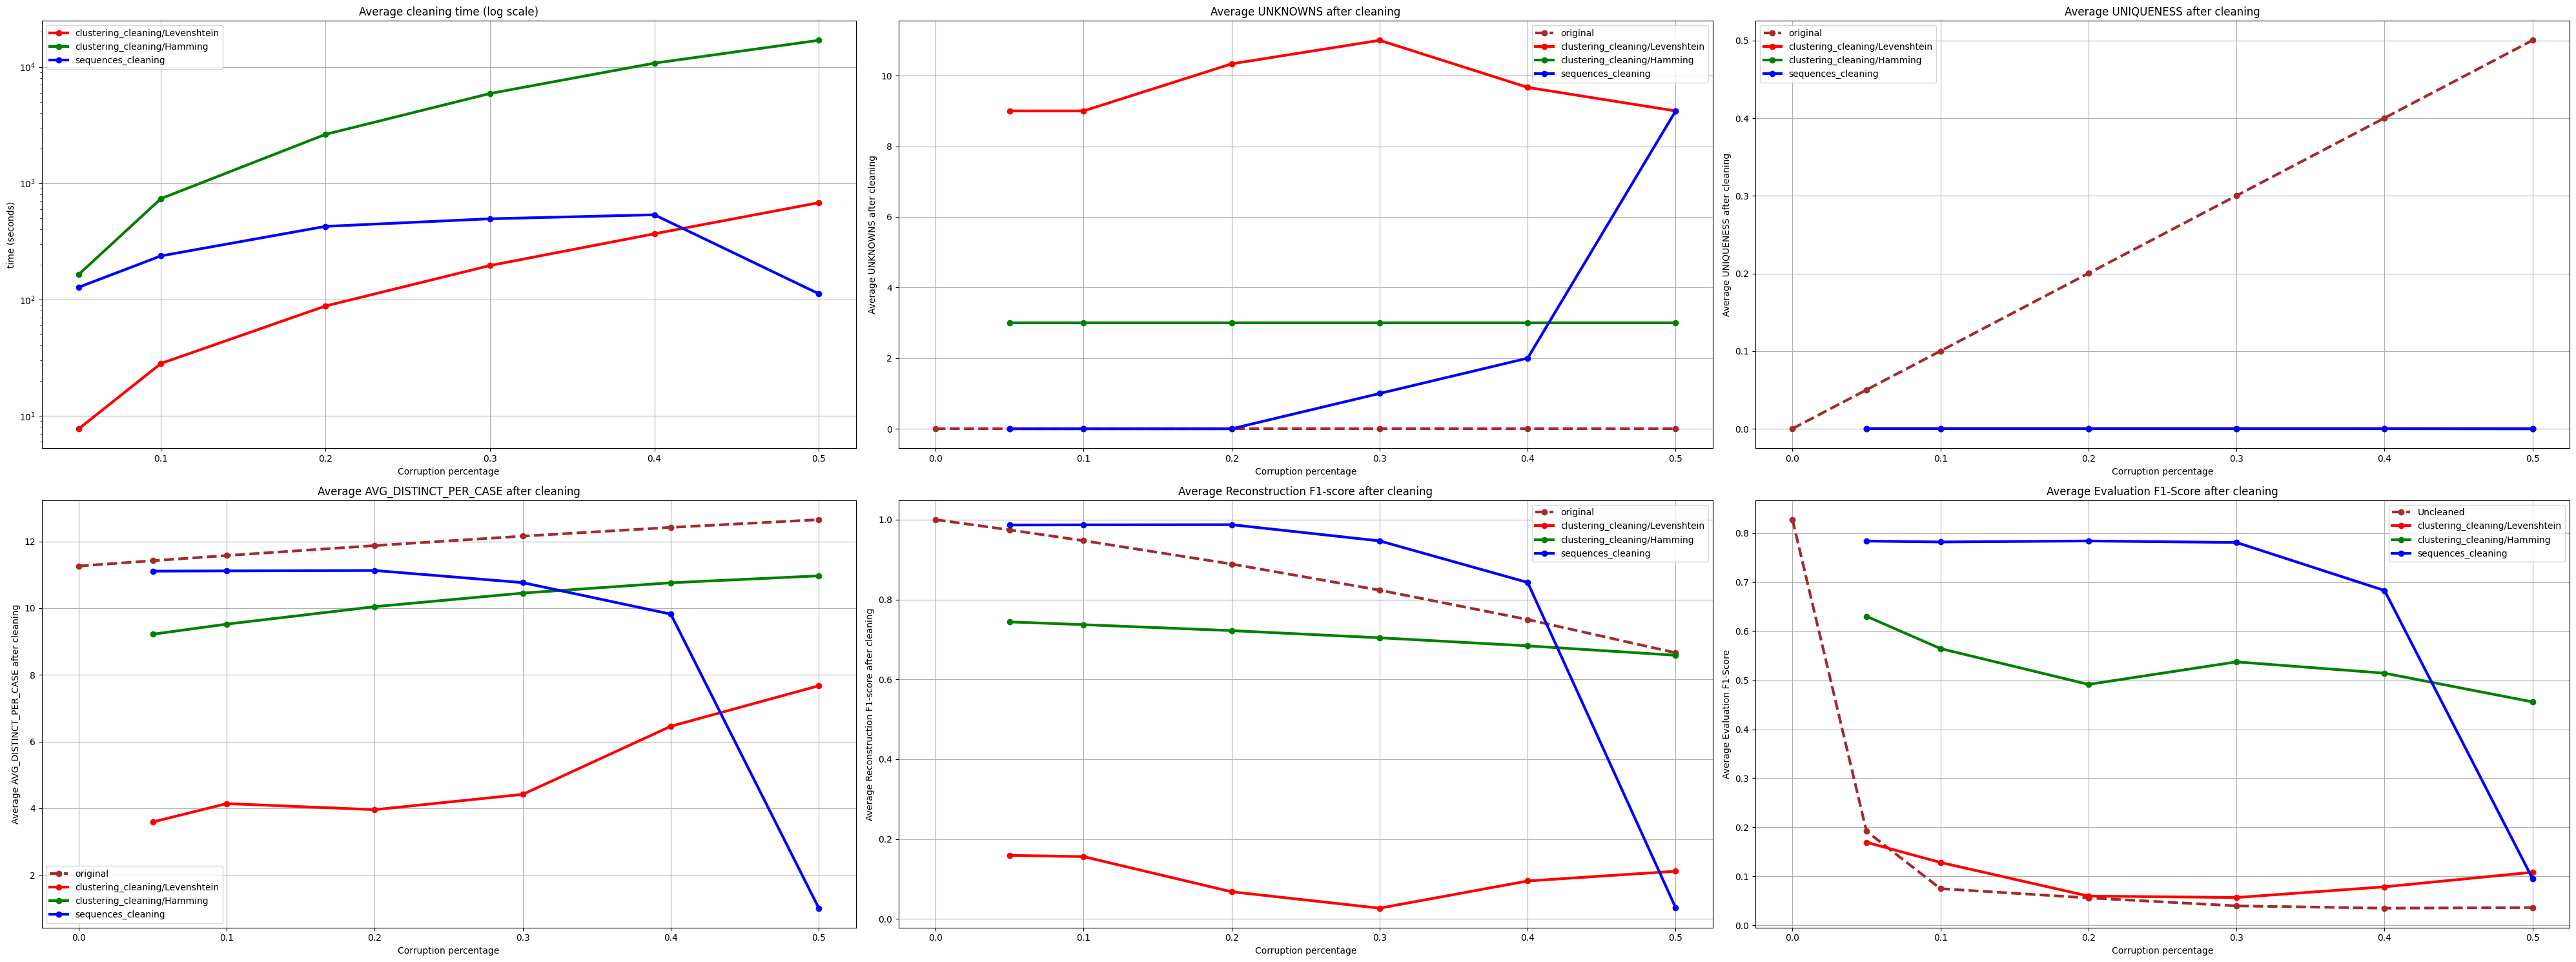

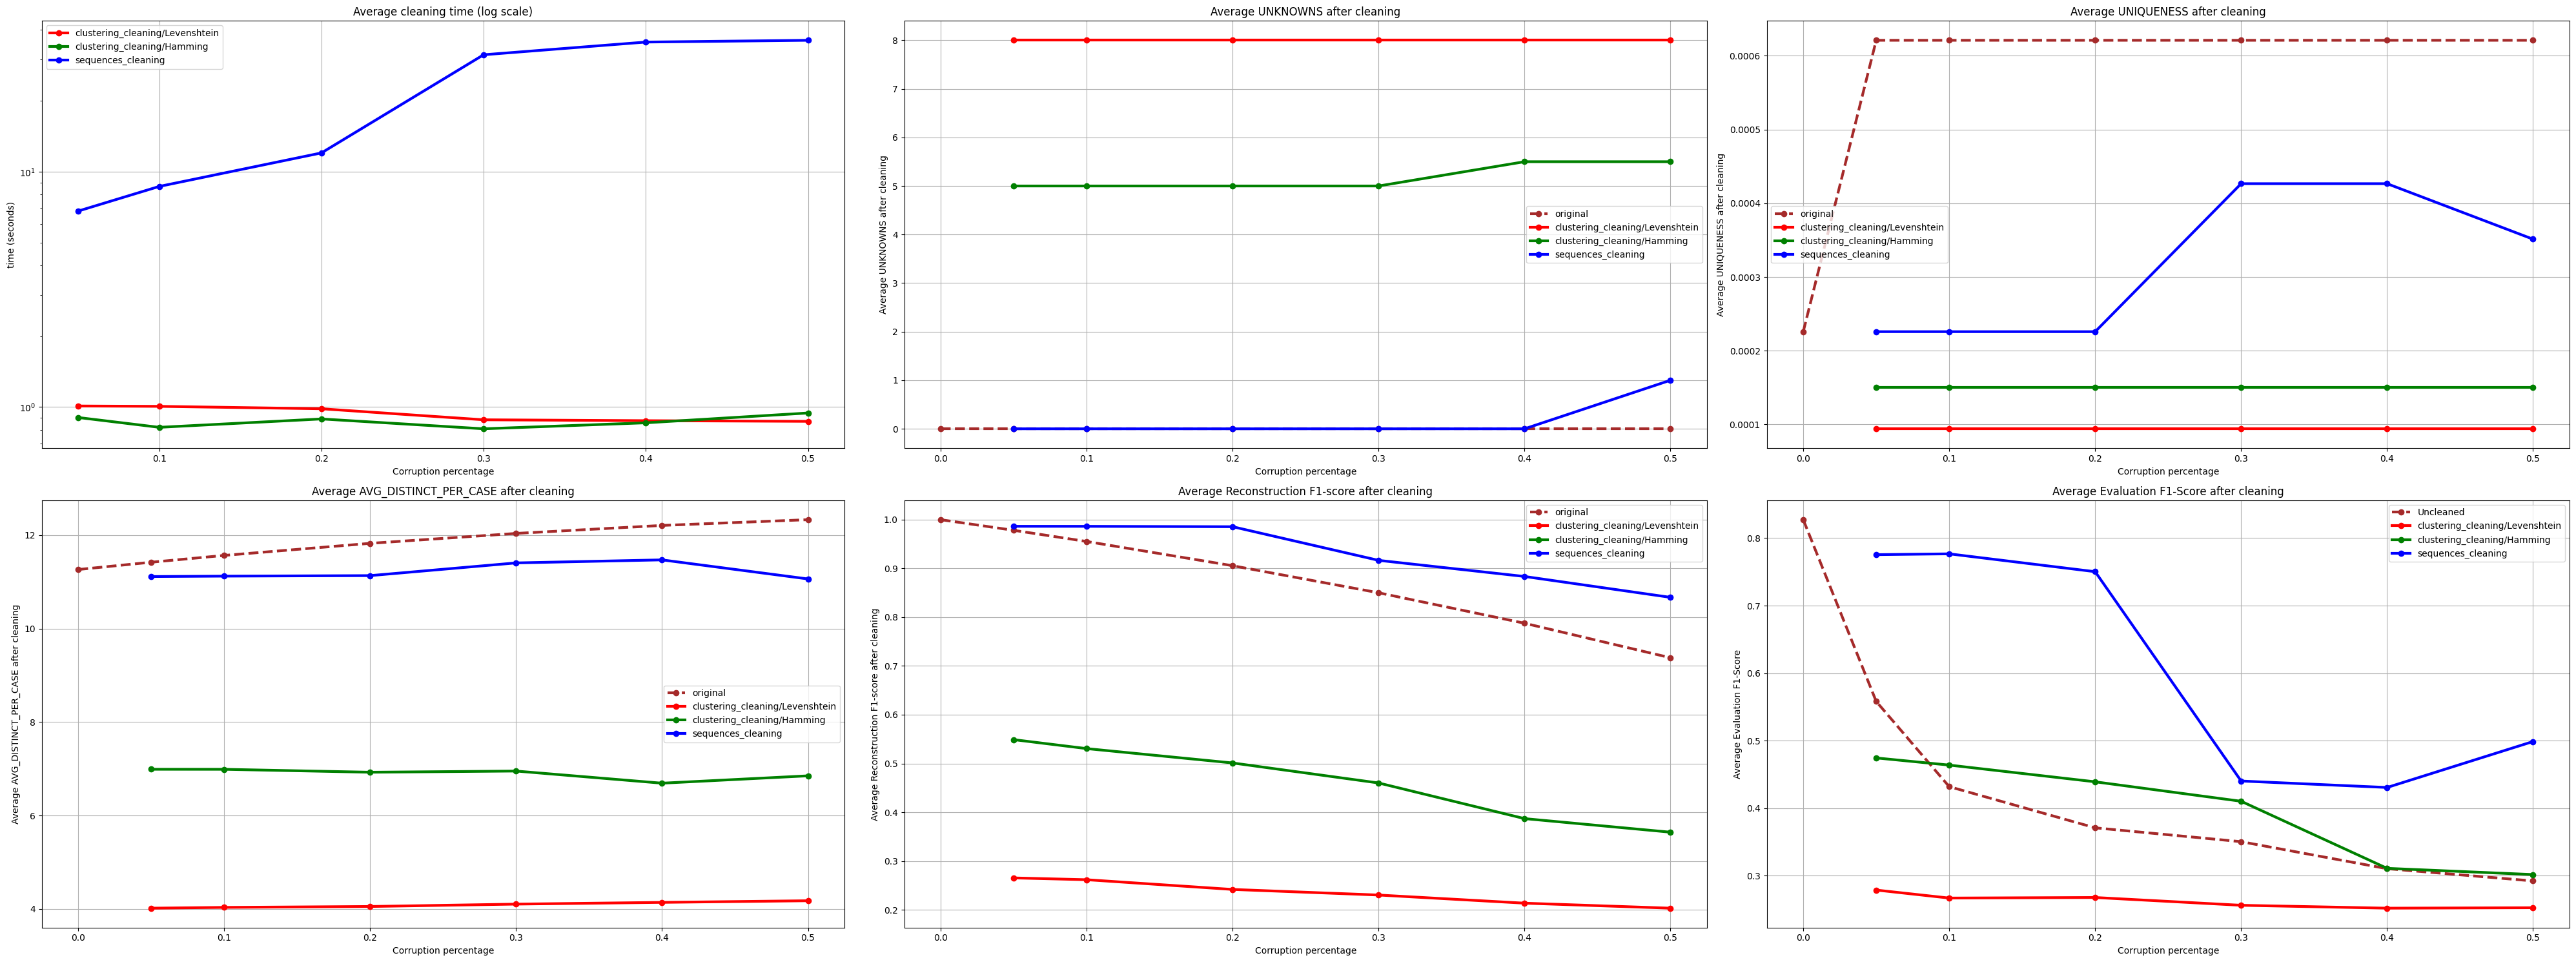

In [ ]:
for pollution_type in pollution_types_3:
  show_compact(dataset, pollution_type)

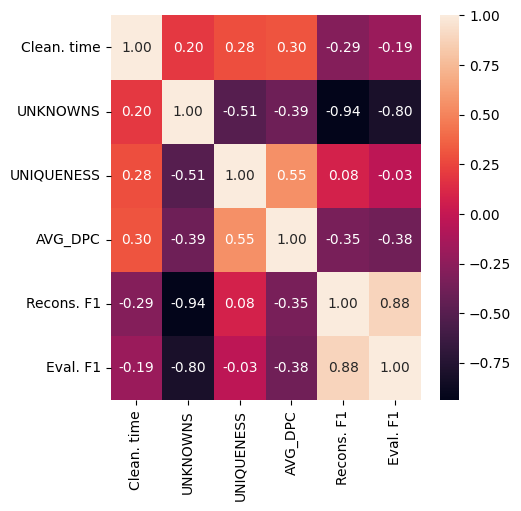

In [ ]:
corr = correlation_analysis(dataset)
plt.figure(figsize=(5,5))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.savefig(f"corr_{dataset2Short[dataset]}.png", bbox_inches='tight')